# Core

> Lisette Core

In [ ]:
#| default_exp core

In [ ]:
#| hide
from cachy import enable_cachy,disable_cachy

In [ ]:
#| hide
enable_cachy()

In [ ]:
#| export
import asyncio, base64, io, json, litellm, mimetypes, random, string
from typing import Optional
from html import escape
from litellm import (acompletion, completion, stream_chunk_builder, Message,
                     ModelResponse, ModelResponseStream, get_model_info, register_model, Usage)
from litellm.utils import function_to_dict, StreamingChoices, Delta, ChatCompletionMessageToolCall, Function, Choices
from toolslm.funccall import mk_ns, call_func, call_func_async, get_schema
from fastcore.utils import *
from fastcore import imghdr
from dataclasses import dataclass

In [ ]:
#| hide
from fastcore.test import *
from IPython.display import Markdown, Image
from fastcore.xtras import SaveReturn
from fastcore.test import *
from IPython.display import Audio, Video
import httpx

# LiteLLM

## Deterministic outputs

LiteLLM `ModelResponse(Stream)` objects have `id` and `created_at` fields that are generated dynamically. Even when we use [`cachy`](https://github.com/answerdotai/cachy) to cache the LLM response these dynamic fields create diffs which makes code review more challenging. The patches below ensure that `id` and `created_at` fields are fixed and won't generate diffs.

In [ ]:
#| export
def patch_litellm(seed=0):
    "Patch litellm.ModelResponseBase such that `id` and `created` are fixed."
    from litellm.types.utils import ModelResponseBase
    @patch
    def __init__(self: ModelResponseBase, id=None, created=None, *args, **kwargs): 
        self._orig___init__(id='chatcmpl-xxx', created=1000000000, *args, **kwargs)

    @patch
    def __setattr__(self: ModelResponseBase, name, value):
        if name == 'id': value = 'chatcmpl-xxx'
        elif name == 'created': value = 1000000000
        self._orig___setattr__(name, value)

    if seed is not None: random.seed(seed) # ensures random ids like tool call ids are deterministic

In [ ]:
patch_litellm()

## Completion

LiteLLM provides an convenient unified interface for most big LLM providers. Because it's so useful to be able to switch LLM providers with just one argument. We want to make it even easier to by adding some more convenience functions and classes. 

This is very similar to our other wrapper libraries for popular AI providers: [claudette](https://claudette.answer.ai/) (Anthropic), [gaspard](https://github.com/AnswerDotAI/gaspard) (Gemini), [cosette](https://answerdotai.github.io/cosette/) (OpenAI).

In [ ]:
#| export
@patch
def _repr_markdown_(self: litellm.ModelResponse):
    message = self.choices[0].message
    content = ''
    if mc:=message.content: content += mc[0]['text'] if isinstance(mc,list) else mc
    if message.tool_calls:
        tool_calls = [f"\n\n🔧 {nested_idx(tc,'function','name')}({nested_idx(tc,'function','arguments')})\n" for tc in message.tool_calls]
        content += "\n".join(tool_calls)
    for img in getattr(message, 'images', []): content += f"\n\n![generated image]({nested_idx(img, 'image_url', 'url')})"
    if not content: content = str(message)
    details = [f"id: `{self.id}`", f"model: `{self.model}`", f"finish_reason: `{self.choices[0].finish_reason}`"]
    if hasattr(self, 'usage') and self.usage: details.append(f"usage: `{self.usage}`")
    det_str = '\n- '.join(details)
    return f"""{content}

<details>

- {det_str}

</details>"""

In [ ]:
#| export
sonn45 = "claude-sonnet-4-5"

In [ ]:
# litellm._turn_on_debug()

In [ ]:
ms = ["gemini/gemini-3-pro-preview", "gemini/gemini-2.5-flash", "claude-sonnet-4-5", "openai/gpt-4.1"]
msg = [{'role':'user','content':'Hey there!', 'cache_control': {'type': 'ephemeral'}}]
for m in ms:
    display(Markdown(f'**{m}:**'))
    display(completion(m,msg))

**gemini/gemini-3-pro-preview:**

Hello! How’s it going?

I’m here and ready to help with whatever you need—whether it’s brainstorming ideas, writing code, answering a tricky question, or just chatting.

What’s on your mind today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=169, prompt_tokens=4, total_tokens=173, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=119, rejected_prediction_tokens=None, text_tokens=50, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=4, image_tokens=None))`

</details>

**gemini/gemini-2.5-flash:**

Hey there! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=153, prompt_tokens=4, total_tokens=157, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=143, rejected_prediction_tokens=None, text_tokens=10, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=4, image_tokens=None))`

</details>

**claude-sonnet-4-5:**

Hello! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=12, prompt_tokens=10, total_tokens=22, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

**openai/gpt-4.1:**

Hello! How can I help you today? 😊

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=10, prompt_tokens=10, total_tokens=20, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

The markdown repr also covers image outputs:

Here's a charcoal sketch of two dogs playing outside, viewed from a window, as you requested! 

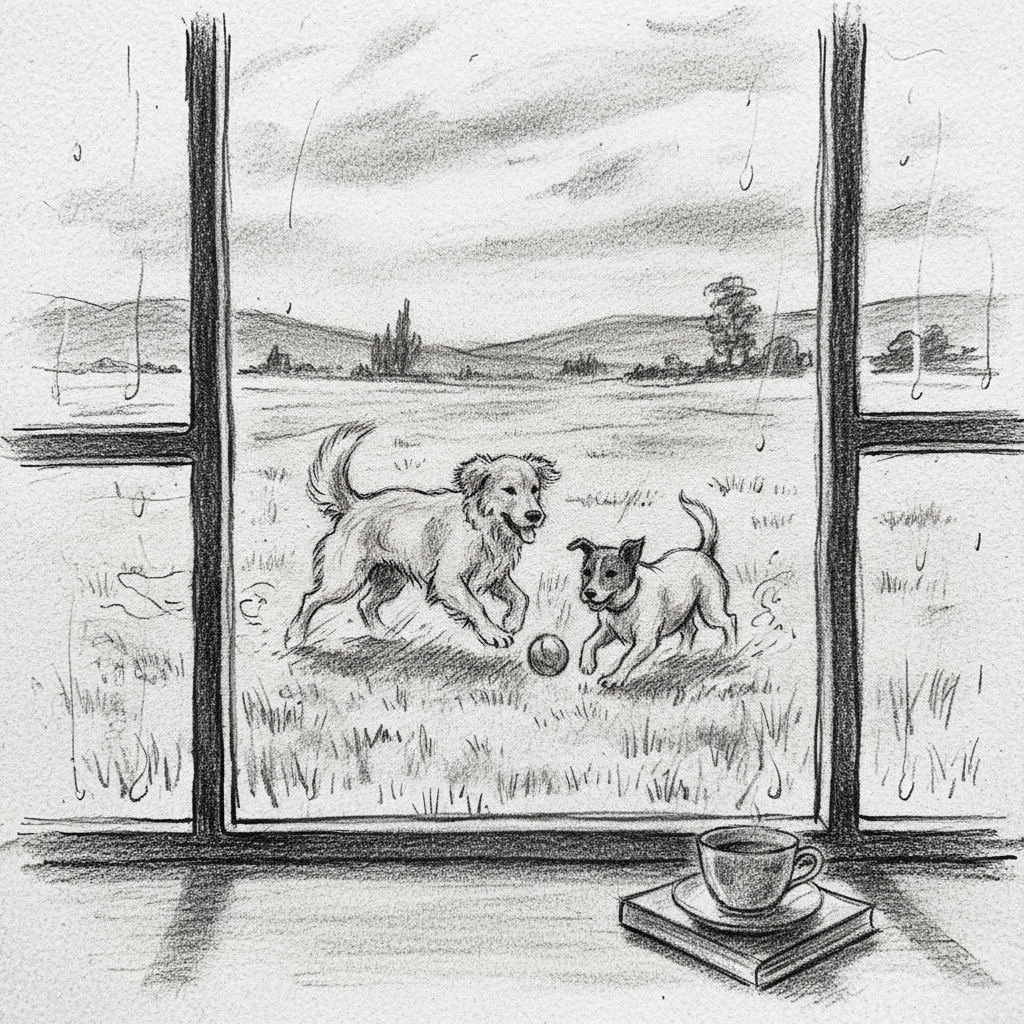

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash-image-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=1312, prompt_tokens=15, total_tokens=1327, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=22, image_tokens=1290), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=15, image_tokens=None))`

</details>

In [ ]:
completion('gemini/gemini-2.5-flash-image-preview',[{'role':'user','content':'Generate a charcoal sketch of two dogs playing outside as viewed from a window'}])


## Messages formatting

Let's start with making it easier to pass messages into litellm's `completion` function (including images, and pdf files).

In [ ]:
#| export
#| export
_sigs = {
    (b'%PDF', 0): 'application/pdf',
    (b'RIFF', 0): lambda d: 'audio/wav' if d[8:12]==b'WAVE' else 'video/avi' if d[8:12]==b'AVI ' else None,
    (b'ID3', 0): 'audio/mp3',
    (b'\xff\xfb', 0): 'audio/mp3',
    (b'\xff\xf3', 0): 'audio/mp3',
    (b'FORM', 0): lambda d: 'audio/aiff' if d[8:12]==b'AIFF' else None,
    (b'OggS', 0): 'audio/ogg',
    (b'fLaC', 0): 'audio/flac',
    (b'ftyp', 4): lambda d: 'video/3gpp' if d[8:11]==b'3gp' else 'video/mp4',
    (b'\x1a\x45\xdf', 0): 'video/webm',
    (b'FLV', 0): 'video/x-flv',
    (b'\x30\x26\xb2\x75', 0): 'video/wmv',
    (b'\x00\x00\x01\xb3', 0): 'video/mpeg',
}

def _detect_mime(data):
    for (sig,pos),mime in _sigs.items():
        if data[pos:pos+len(sig)]==sig: return mime(data) if callable(mime) else mime
    return mimetypes.types_map.get(f'.{imghdr.what(None, h=data)}')
    
def _bytes2content(data):
    "Convert bytes to litellm content dict (image, pdf, audio, video)"
    mtype = _detect_mime(data)
    if not mtype: raise ValueError(f'Data must be a supported file type, got {data[:10]}')
    encoded = base64.b64encode(data).decode("utf-8")    
    if mtype.startswith('image/'): return {'type': 'image_url', 'image_url': f'data:{mtype};base64,{encoded}'}
    return {'type': 'file', 'file': {'file_data': f'data:{mtype};base64,{encoded}'}}

In [ ]:
#| export
def _add_cache_control(msg,          # LiteLLM formatted msg
                       ttl=None):    # Cache TTL: '5m' (default) or '1h'
    "cache `msg` with default time-to-live (ttl) of 5minutes ('5m'), but can be set to '1h'."
    if isinstance(msg["content"], str): 
        msg["content"] = [{"type": "text", "text": msg["content"]}]
    cache_control = {"type": "ephemeral"}
    if ttl is not None: cache_control["ttl"] = ttl
    if isinstance(msg["content"], list) and msg["content"]:
        msg["content"][-1]["cache_control"] = cache_control
    return msg

def _has_cache(msg):
    return msg["content"] and isinstance(msg["content"], list) and ('cache_control' in msg["content"][-1])

def remove_cache_ckpts(msg):
    "remove cache checkpoints and return msg."
    if _has_cache(msg): msg["content"][-1].pop('cache_control', None)
    return msg

def _mk_content(o):
    if isinstance(o, str): return {'type':'text','text':o.strip() or '.'}
    elif isinstance(o,bytes): return _bytes2content(o)
    return o

def contents(r):
    "Get message object from response `r`."
    return r.choices[0].message

In [ ]:
#| export
def mk_msg(
    content,      # Content: str, bytes (image), list of mixed content, or dict w 'role' and 'content' fields
    role="user",  # Message role if content isn't already a dict/Message
    cache=False,  # Enable Anthropic caching
    ttl=None      # Cache TTL: '5m' (default) or '1h'
):
    "Create a LiteLLM compatible message."
    if isinstance(content, dict) or isinstance(content, Message): return content
    if isinstance(content, ModelResponse): return contents(content)
    if isinstance(content, list) and len(content) == 1 and isinstance(content[0], str): c = content[0]
    elif isinstance(content, list): c = [_mk_content(o) for o in content]
    else: c = content
    msg = {"role": role, "content": c}
    return _add_cache_control(msg, ttl=ttl) if cache else msg

Now we can use mk_msg to create different types of messages.

Simple text:

In [ ]:
msg = mk_msg("hey")
msg

{'role': 'user', 'content': 'hey'}

Which can be passed to litellm's `completion` function like this:

In [ ]:
model = ms[0]

In [ ]:
res = completion(model, [msg])
res

Hey there! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=129, prompt_tokens=2, total_tokens=131, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=119, rejected_prediction_tokens=None, text_tokens=10, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=2, image_tokens=None))`

</details>

We'll add a little shortcut to make examples and testing easier here:

In [ ]:
def c(msgs, m=model, **kw):
    msgs = [msgs] if isinstance(msgs,dict) else listify(msgs)
    return completion(m, msgs, **kw)

In [ ]:
c(msg)

Hey there! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=129, prompt_tokens=2, total_tokens=131, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=119, rejected_prediction_tokens=None, text_tokens=10, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=2, image_tokens=None))`

</details>

Lists w just one string element are flattened for conciseness:

In [ ]:
test_eq(mk_msg("hey"), mk_msg(["hey"]))

(LiteLLM ignores these fields when sent to other providers)

Text and images:

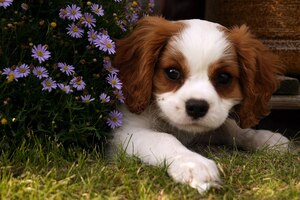

In [ ]:
img_fn = Path('samples/puppy.jpg')
Image(filename=img_fn, width=200)

In [ ]:
msg = mk_msg(['hey what in this image?',img_fn.read_bytes()])
print(json.dumps(msg,indent=1)[:200]+"...")

{
 "role": "user",
 "content": [
  {
   "type": "text",
   "text": "hey what in this image?"
  },
  {
   "type": "image_url",
   "image_url": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/4gxUSU...


In [ ]:
c(msg)

Based on the image, here is what appears to be in it:

*   **A Puppy:** The main subject is a young Cavalier King Charles Spaniel puppy. It has distinctive chestnut and white markings (often referred to as "Blenheim" coloring), floppy ears, and large, dark eyes. It is lying down on its stomach with its front paws stretched out.
*   **Flowers:** To the left of the puppy, there is a cluster of small, purple aster-like flowers growing on a green bush.
*   **Grass:** The puppy is resting on green grass.
*   **Background:** Behind the puppy, there appears to be a dark, possibly wooden structure or planter pot, though it is slightly out of focus.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=273, prompt_tokens=1087, total_tokens=1360, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=119, rejected_prediction_tokens=None, text_tokens=154, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=7, image_tokens=None))`

</details>

Let's also demonstrate this for PDFs

In [ ]:
pdf_fn = Path('samples/solveit.pdf')
msg = mk_msg(['Who is the author of this pdf?', pdf_fn.read_bytes()])
c(msg)

Based on the text in the screenshot, the author is **Jeremy Howard**.

This is explicitly stated in the bold heading: **"Hi, I'm Jeremy Howard, from fast.ai"**.

He goes on to describe his work, including launching fast.ai and creating the "solveit" method.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=182, prompt_tokens=541, total_tokens=723, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=118, rejected_prediction_tokens=None, text_tokens=64, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=9, image_tokens=None))`

</details>

Some models like Gemini support audio and video:

In [ ]:
wav_data = httpx.get("https://openaiassets.blob.core.windows.net/$web/API/docs/audio/alloy.wav").content
# Audio(wav_data)  # uncomment to preview

In [ ]:
msg = mk_msg(['What is this audio saying?', wav_data])
completion(ms[1], [msg])

The sun rises in the east and sets in the west. This simple fact has been observed by humans for thousands of years.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=94, prompt_tokens=230, total_tokens=324, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=69, rejected_prediction_tokens=None, text_tokens=25, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=223, cached_tokens=None, text_tokens=7, image_tokens=None))`

</details>

In [ ]:
vid_data = httpx.get("https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/pixel8.mp4").content

In [ ]:
msg = mk_msg(['Concisely, what is happening in this video?', vid_data])
completion(ms[1], [msg])

A photographer, Saeka Shimada, explores Tokyo at night, demonstrating a new Google Pixel phone's "Video Boost" feature. This feature uses "Night Sight" to significantly enhance the brightness and quality of low-light video, allowing her to capture vibrant scenes in dimly lit alleys, with a clear before-and-after comparison of the boosted footage. She concludes her evening in Shibuya with friends.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=1041, prompt_tokens=17402, total_tokens=18443, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=960, rejected_prediction_tokens=None, text_tokens=81, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=1873, cached_tokens=None, text_tokens=12, image_tokens=None))`

</details>

### Caching

Some providers such as Anthropic require manually opting into caching. Let's try it:

In [ ]:
def cpr(i): return f'{i} '*1024 + 'This is a caching test. Report back only what number you see repeated above.'

In [ ]:
#| eval: false
disable_cachy()

In [ ]:
# msg = mk_msg(cpr(1), cache=True)
# res = c(msg, ms[2])
# res

Anthropic has a maximum of 4 cache checkpoints, so we remove previous ones as we go:

In [ ]:
# res = c([remove_cache_ckpts(msg), mk_msg(res), mk_msg(cpr(2), cache=True)], ms[2])
# res

We see that the first message was cached, and this extra message has been written to cache:

In [ ]:
# res.usage.prompt_tokens_details

We can add a bunch of large messages in a loop to see how the number of cached tokens used grows.

We do this for 25 times to ensure it still works for more than >20 content blocks, [which is a known anthropic issue](https://docs.claude.com/en/docs/build-with-claude/prompt-caching).

The code below is commented by default, because it's slow. Please uncomment when working on caching.

In [ ]:
# h = []
# msg = mk_msg(cpr(1), cache=True)

# for o in range(2,25):
#     h += [remove_cache_ckpts(msg), mk_msg(res)]
#     msg = mk_msg(cpr(o), cache=True)
#     res = c(h+[msg])
#     detls = res.usage.prompt_tokens_details
#     print(o, detls.cached_tokens, detls.cache_creation_tokens, end='; ')

In [ ]:
enable_cachy()

### Reconstructing formatted outputs

Lisette can call multiple tools in a loop. Further down this notebook, we'll provide convenience functions for formatting such a sequence of toolcalls and responses into one formatted output string.

For now, we'll show an example and show how to transform such a formatted output string back into a valid LiteLLM history.

In [ ]:
fmt_outp = '''
I'll solve this step-by-step, using parallel calls where possible.

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01KjnQH2Nsz2viQ7XYpLW3Ta",
  "call": { "function": "simple_add", "arguments": { "a": 10, "b": 5 } },
  "result": "15"
}
```

</details>

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01Koi2EZrGZsBbnQ13wuuvzY",
  "call": { "function": "simple_add", "arguments": { "a": 2, "b": 1 } },
  "result": "3"
}
```

</details>

Now I need to multiply 15 * 3 before I can do the final division:

<details class='tool-usage-details'>

```json
{
  "id": "toolu_0141NRaWUjmGtwxZjWkyiq6C",
  "call": { "function": "multiply", "arguments": { "a": 15, "b": 3 } },
  "result": "45"
}
```

</details>
'''

In [ ]:
#| export
detls_tag = "<details class='tool-usage-details'>"
re_tools = re.compile(fr"^({detls_tag}\n+```json\n+(.*?)\n+```\n+</details>)", flags=re.DOTALL|re.MULTILINE)

We can split into chunks of (text,toolstr,json):

In [ ]:
sp = re_tools.split(fmt_outp)
for o in list(chunked(sp, 3, pad=True)): print('- ', o)

-  ["\nI'll solve this step-by-step, using parallel calls where possible.\n\n", '<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_01KjnQH2Nsz2viQ7XYpLW3Ta",\n  "call": { "function": "simple_add", "arguments": { "a": 10, "b": 5 } },\n  "result": "15"\n}\n```\n\n</details>', '{\n  "id": "toolu_01KjnQH2Nsz2viQ7XYpLW3Ta",\n  "call": { "function": "simple_add", "arguments": { "a": 10, "b": 5 } },\n  "result": "15"\n}']
-  ['\n\n', '<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_01Koi2EZrGZsBbnQ13wuuvzY",\n  "call": { "function": "simple_add", "arguments": { "a": 2, "b": 1 } },\n  "result": "3"\n}\n```\n\n</details>', '{\n  "id": "toolu_01Koi2EZrGZsBbnQ13wuuvzY",\n  "call": { "function": "simple_add", "arguments": { "a": 2, "b": 1 } },\n  "result": "3"\n}']
-  ['\n\nNow I need to multiply 15 * 3 before I can do the final division:\n\n', '<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_0141NRaWUjmGtwxZjWkyiq6C",\n  "call": { "func

In [ ]:
#| export
def _extract_tool(text:str)->tuple[dict,dict]:
    "Extract tool call and results from <details> block"
    d = json.loads(text.strip())
    call = d['call']
    func = call['function']
    tc = ChatCompletionMessageToolCall(Function(dumps(call['arguments']),func), d['id'])
    tr = {'role': 'tool','tool_call_id': d['id'],'name': func, 'content': d['result']}
    return tc,tr

def fmt2hist(outp:str)->list:
    "Transform a formatted output into a LiteLLM compatible history"
    lm,hist = Message(),[]
    spt = re_tools.split(outp)
    for txt,_,tooljson in chunked(spt, 3, pad=True):
        txt = txt.strip() if tooljson or txt.strip() else '.'
        hist.append(lm:=Message(txt))
        if tooljson:
            tcr = _extract_tool(tooljson)
            if not hist: hist.append(lm) # if LLM calls a tool without talking
            lm.tool_calls = lm.tool_calls+[tcr[0]] if lm.tool_calls else [tcr[0]] 
            hist.append(tcr[1])
    return hist

See how we can turn that one formatted output string back into a list of Messages:

In [ ]:
from pprint import pprint

In [ ]:
h = fmt2hist(fmt_outp)
pprint(h)

[Message(content="I'll solve this step-by-step, using parallel calls where possible.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":10,"b":5}', name='simple_add'), id='toolu_01KjnQH2Nsz2viQ7XYpLW3Ta', type='function')], function_call=None, provider_specific_fields=None),
 {'content': '15',
  'name': 'simple_add',
  'role': 'tool',
  'tool_call_id': 'toolu_01KjnQH2Nsz2viQ7XYpLW3Ta'},
 Message(content='', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":2,"b":1}', name='simple_add'), id='toolu_01Koi2EZrGZsBbnQ13wuuvzY', type='function')], function_call=None, provider_specific_fields=None),
 {'content': '3',
  'name': 'simple_add',
  'role': 'tool',
  'tool_call_id': 'toolu_01Koi2EZrGZsBbnQ13wuuvzY'},
 Message(content='Now I need to multiply 15 * 3 before I can do the final division:', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":15,"b":3}', name='

### `mk_msgs`

We will skip tool use blocks and tool results during caching

In [ ]:
#| export
def _apply_cache_idxs(msgs, cache_idxs=[-1], ttl=None):
    'Add cache control to idxs after filtering tools'
    ms = L(msgs).filter(lambda m: not (m.get('tool_calls', []) or m['role'] == 'tool'))
    for i in cache_idxs:
        try: _add_cache_control(ms[i], ttl)
        except IndexError: continue

Now lets make it easy to provide entire conversations:

In [ ]:
#| export
def mk_msgs(
    msgs,                   # List of messages (each: str, bytes, list, or dict w 'role' and 'content' fields)
    cache=False,            # Enable Anthropic caching
    cache_idxs=[-1],        # Cache breakpoint idxs
    ttl=None,               # Cache TTL: '5m' (default) or '1h'
):
    "Create a list of LiteLLM compatible messages."
    if not msgs: return []
    if not isinstance(msgs, list): msgs = [msgs]
    res,role = [],'user'
    msgs = L(msgs).map(lambda m: fmt2hist(m) if detls_tag in m else [m]).concat()
    for m in msgs:
        res.append(msg:=remove_cache_ckpts(mk_msg(m, role=role)))
        role = 'assistant' if msg['role'] in ('user','function', 'tool') else 'user'
    if cache: _apply_cache_idxs(res, cache_idxs, ttl)
    return res

With `mk_msgs` you can easily provide a whole conversation:

In [ ]:
msgs = mk_msgs(['Hey!',"Hi there!","How are you?","I'm doing fine and you?"])
msgs

[{'role': 'user', 'content': 'Hey!'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user', 'content': 'How are you?'},
 {'role': 'assistant', 'content': "I'm doing fine and you?"}]

By defualt the last message will be cached when `cache=True`:

In [ ]:
msgs = mk_msgs(['Hey!',"Hi there!","How are you?","I'm doing fine and you?"], cache=True)
msgs

[{'role': 'user', 'content': 'Hey!'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user', 'content': 'How are you?'},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': "I'm doing fine and you?",
    'cache_control': {'type': 'ephemeral'}}]}]

In [ ]:
test_eq('cache_control' in msgs[-1]['content'][0], True)

Alternatively, users can provide custom `cache_idxs`. Tool call blocks and results are skipped during caching:

In [ ]:
msgs = mk_msgs(['Hello!','Hi! How can I help you?','Call some functions!',fmt_outp], cache=True, cache_idxs=[0,-2,-1])
msgs

[{'role': 'user',
  'content': [{'type': 'text',
    'text': 'Hello!',
    'cache_control': {'type': 'ephemeral'}}]},
 {'role': 'assistant', 'content': 'Hi! How can I help you?'},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': 'Call some functions!',
    'cache_control': {'type': 'ephemeral'}}]},
 Message(content="I'll solve this step-by-step, using parallel calls where possible.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":10,"b":5}', name='simple_add'), id='toolu_01KjnQH2Nsz2viQ7XYpLW3Ta', type='function')], function_call=None, provider_specific_fields=None),
 {'role': 'tool',
  'tool_call_id': 'toolu_01KjnQH2Nsz2viQ7XYpLW3Ta',
  'name': 'simple_add',
  'content': '15'},
 Message(content='', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":2,"b":1}', name='simple_add'), id='toolu_01Koi2EZrGZsBbnQ13wuuvzY', type='function')], function_call=None, provider_specific_fields=None),

In [ ]:
test_eq('cache_control' in msgs[0]['content'][0], True)
test_eq('cache_control' in msgs[2]['content'][0], True) # shifted idxs to skip tools
test_eq('cache_control' in msgs[-1]['content'][0], True)

Who's speaking at when is automatically inferred.
Even when there are multiple tools being called in parallel (which LiteLLM supports!).

In [ ]:
msgs = mk_msgs(['Tell me the weather in Paris and Rome',
                'Assistant calls weather tool two times',
                {'role':'tool','content':'Weather in Paris is ...'},
                {'role':'tool','content':'Weather in Rome is ...'},
                'Assistant returns weather',
                'Thanks!'])
msgs

[{'role': 'user', 'content': 'Tell me the weather in Paris and Rome'},
 {'role': 'assistant', 'content': 'Assistant calls weather tool two times'},
 {'role': 'tool', 'content': 'Weather in Paris is ...'},
 {'role': 'tool', 'content': 'Weather in Rome is ...'},
 {'role': 'assistant', 'content': 'Assistant returns weather'},
 {'role': 'user', 'content': 'Thanks!'}]

In [ ]:
#| hide
test_eq([m['role'] for m in msgs],['user','assistant','tool','tool','assistant','user'])

For ease of use, if `msgs` is not already in a `list`, it will automatically be wrapped inside one. This way you can pass a single prompt into `mk_msgs` and get back a LiteLLM compatible msg history.

In [ ]:
msgs = mk_msgs("Hey")
msgs

[{'role': 'user', 'content': 'Hey'}]

In [ ]:
#| hide
msgs = mk_msgs({'role':'tool','content':'fake tool result'})
msgs

[{'role': 'tool', 'content': 'fake tool result'}]

In [ ]:
msgs = mk_msgs(['Hey!',"Hi there!","How are you?","I'm fine, you?"])
msgs

[{'role': 'user', 'content': 'Hey!'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user', 'content': 'How are you?'},
 {'role': 'assistant', 'content': "I'm fine, you?"}]

However, beware that if you use `mk_msgs` for a single message, consisting of multiple parts.
Then you should be explicit, and make sure to wrap those multiple messages in two lists:

1. One list to show that they belong together in one message (the inner list).
2. Another, because mk_msgs expects a list of multiple messages (the outer list).

This is common when working with images for example:

In [ ]:
msgs = mk_msgs([['Whats in this img?',img_fn.read_bytes()]])
print(json.dumps(msgs,indent=1)[:200]+"...")

[
 {
  "role": "user",
  "content": [
   {
    "type": "text",
    "text": "Whats in this img?"
   },
   {
    "type": "image_url",
    "image_url": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD...


## Streaming

LiteLLM supports streaming responses. That's really useful if you want to show intermediate results, instead of having to wait until the whole response is finished.

We create this helper function that returns the entire response at the end of the stream. This is useful when you want to store the whole response somewhere after having displayed the intermediate results.

In [ ]:
#| export
def stream_with_complete(gen, postproc=noop):
    "Extend streaming response chunks with the complete response"
    chunks = []
    for chunk in gen:
        chunks.append(chunk)
        yield chunk
    postproc(chunks)
    return stream_chunk_builder(chunks)

In [ ]:
r = c(mk_msgs("Hey!"), stream=True)
r2 = SaveReturn(stream_with_complete(r))

In [ ]:
for o in r2:
    cts = o.choices[0].delta.content
    if cts: print(cts, end='')

Hey there! How can I help you today?

Whether you have a specific question, need help with a project, or just want to chat, I'm here for it. What's on your mind?

In [ ]:
r2.value

Hey there! How can I help you today?

Whether you have a specific question, need help with a project, or just want to chat, I'm here for it. What's on your mind?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=161, prompt_tokens=3, total_tokens=164, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=5, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

## Tools

In [ ]:
#| export
def lite_mk_func(f):
    if isinstance(f, dict): return f
    return {'type':'function', 'function':get_schema(f, pname='parameters')}

In [ ]:
def simple_add(
    a: int,   # first operand
    b: int=0  # second operand
) -> int:
    "Add two numbers together"
    return a + b

In [ ]:
toolsc = lite_mk_func(simple_add)
toolsc

{'type': 'function',
 'function': {'name': 'simple_add',
  'description': 'Add two numbers together\n\nReturns:\n- type: integer',
  'parameters': {'type': 'object',
   'properties': {'a': {'type': 'integer', 'description': 'first operand'},
    'b': {'type': 'integer', 'description': 'second operand', 'default': 0}},
   'required': ['a']}}}

In [ ]:
tmsg = mk_msg("What is 5478954793+547982745? How about 5479749754+9875438979? Always use tools for calculations, and describe what you'll do before using a tool. Where multiple tool calls are required, do them in a single response where possible. ")
r = c(tmsg, tools=[toolsc])

In [ ]:
display(r)

I will first calculate the sum of 5478954793 and 547982745. Then, I will calculate the sum of 5479749754 and 9875438979.



🔧 simple_add({"a": 5478954793, "b": 547982745})



🔧 simple_add({"a": 5479749754, "b": 9875438979})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=262, prompt_tokens=160, total_tokens=422, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=128, rejected_prediction_tokens=None, text_tokens=134, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=160, image_tokens=None))`

</details>

A tool response can be a string or a list of tool blocks (e.g., an image url block). To allow users to specify if a response should not be immediately stringified, we provide the ToolResponse datatype users can wrap their return statement in.

In [ ]:
#| export
@dataclass
class ToolResponse:
    content: list[str,str]

In [ ]:
#| export
def _lite_call_func(tc,ns,raise_on_err=True):
    try: fargs = json.loads(tc.function.arguments)
    except Exception as e: raise ValueError(f"Failed to parse function arguments: {tc.function.arguments}") from e
    res = call_func(tc.function.name, fargs,ns=ns)
    if isinstance(res, ToolResponse): res = res.content
    else: res = str(res)
    return {"tool_call_id": tc.id, "role": "tool", "name": tc.function.name, "content": res}

In [ ]:
tcs = [_lite_call_func(o, ns=globals()) for o in r.choices[0].message.tool_calls]
tcs

[{'tool_call_id': 'call_51b95bb1868d4b8bac626f01770e__thought__EpkDCpYDAdHtim8RBTGXbHtPKoDCG3v5cdwh3C5/eTLd+nZcbCEG6Kb51540QtHmGz6FX2MNza7mnuNc/a9iaoA70aL4drlZXZ7RXWudXcqMuF/imzyaZiezCCtW7GZO0lc6FiYGbESZP9350d16Xlx6Bz8GyZwms5wVVvrN1Mkav0FzIe7l0660rpxJapyb2oBU6YO0Yqa8AC8LgSxBVykEoEmqCceJvr+4WR8pxAYKSVSQ4GGtsD8O1NWYUrpEAgtG8d4DEaOuTd6S5WZtxt6tcYhmzPLjVeSuJf8FssA9oNXPZdI4XBeFa5j6y0svg8U09y3UCZDMZteZgDazFaB4Sx67/r1tgm0Ttife9qP7N9My3hgwvoK4LzS23CIqgJUvkPEwA1yEuNga3kynRdq/nMSfrj78gH343zqrPxNyRGTsrfaRTXQB6n69Vqbd+FZ4RejhrvBGCt3eqU6AnyZRZfbpTDO7yIxy5Yq/ICOX7a+GoGmrjTGXCJApFrsNgwSXjxWz/dzqu2lp5XEMlQVCaEU7xoHHm/+IMg==',
  'role': 'tool',
  'name': 'simple_add',
  'content': '6026937538'},
 {'tool_call_id': 'call_e34e77ff046b4b0aa8731f54cc84',
  'role': 'tool',
  'name': 'simple_add',
  'content': '15355188733'}]

In [ ]:
def delta_text(msg):
    "Extract printable content from streaming delta, return None if nothing to print"
    c = msg.choices[0]
    if not c: return c
    if not hasattr(c,'delta'): return None #f'{c}'
    delta = c.delta
    if delta.content: return delta.content
    if delta.tool_calls:
        res = ''.join(f"🔧 {tc.function.name}" for tc in delta.tool_calls if tc.id and tc.function.name)
        if res: return f'\n{res}\n'
    if hasattr(delta,'reasoning_content'): return '🧠' if delta.reasoning_content else '\n\n'
    return None

In [ ]:
r = c(tmsg, stream=True, tools=[toolsc])
r2 = SaveReturn(stream_with_complete(r))
for o in r2: print(delta_text(o) or '', end='')

I will calculate the sum of 5,478,954,793 and 547,982,745, and then I will calculate the sum of 5,479,749,754 and 9,875,438,979 using the addition tool.


🔧 simple_add

🔧 simple_add


In [ ]:
r2.value

I will calculate the sum of 5,478,954,793 and 547,982,745, and then I will calculate the sum of 5,479,749,754 and 9,875,438,979 using the addition tool.



🔧 simple_add({"b": 547982745, "a": 5478954793})



🔧 simple_add({"b": 9875438979, "a": 5479749754})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=279, prompt_tokens=160, total_tokens=439, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=31, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

In [ ]:
msg = mk_msg("Solve this complex math problem: What is the derivative of x^3 + 2x^2 - 5x + 1?")
r = c(msg, stream=True, reasoning_effort="low")
r2 = SaveReturn(stream_with_complete(r))
for o in r2: print(delta_text(o) or '', end='')

🧠🧠To find the derivative of the function $f(x) = x^3 + 2x^2 - 5x + 1$, we will use the **Power Rule** of differentiation.

The Power Rule states that for any term $ax^n$, the derivative is:
$$ \frac{d}{dx}(ax^n) = n \cdot ax^{n-1} $$

We will differentiate the function term by term:

1.  **First term ($x^3$):**
    *   Bring the power (3) down to the front and subtract 1 from the exponent.
    *   Derivative: $3x^{3-1} = 3x^2$

2.  **Second term ($2x^2$):**
    *   Bring the power (2) down to multiply by the coefficient (2) and subtract 1 from the exponent.
    *   Derivative: $2 \cdot 2x^{2-1} = 4x^1$ or just $4x$

3.  **Third term ($-5x$):**
    *   This is technically $-5x^1$. Bring the power (1) down and subtract 1 from the exponent.
    *   Derivative: $1 \cdot -5x^{1-1} = -5x^0$. Since $x^0 = 1$, this simplifies to just $-5$.

4.  **Fourth term ($1$):**
    *   The derivative of any constant number is always 0.
    *   Derivative: $0$

**Combine the results:**

$$ f'(x) = 3x^2 + 

In [ ]:
r2.value

To find the derivative of the function $f(x) = x^3 + 2x^2 - 5x + 1$, we will use the **Power Rule** of differentiation.

The Power Rule states that for any term $ax^n$, the derivative is:
$$ \frac{d}{dx}(ax^n) = n \cdot ax^{n-1} $$

We will differentiate the function term by term:

1.  **First term ($x^3$):**
    *   Bring the power (3) down to the front and subtract 1 from the exponent.
    *   Derivative: $3x^{3-1} = 3x^2$

2.  **Second term ($2x^2$):**
    *   Bring the power (2) down to multiply by the coefficient (2) and subtract 1 from the exponent.
    *   Derivative: $2 \cdot 2x^{2-1} = 4x^1$ or just $4x$

3.  **Third term ($-5x$):**
    *   This is technically $-5x^1$. Bring the power (1) down and subtract 1 from the exponent.
    *   Derivative: $1 \cdot -5x^{1-1} = -5x^0$. Since $x^0 = 1$, this simplifies to just $-5$.

4.  **Fourth term ($1$):**
    *   The derivative of any constant number is always 0.
    *   Derivative: $0$

**Combine the results:**

$$ f'(x) = 3x^2 + 4x - 5 $$

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=488, prompt_tokens=29, total_tokens=517, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=175, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

## Search

LiteLLM provides search, not via tools, but via the special `web_search_options` param.

**Note:** Not all models support web search. LiteLLM's `supports_web_search` field should indicate this, but it's unreliable for some models like `claude-sonnet-4-20250514`. Checking both `supports_web_search` and `search_context_cost_per_query` provides more accurate detection.

In [ ]:
#| export
def _has_search(m):
    i = get_model_info(m)
    return bool(i.get('search_context_cost_per_query') or i.get('supports_web_search'))

In [ ]:
for m in ms: print(m, _has_search(m))

gemini/gemini-3-pro-preview True
gemini/gemini-2.5-flash True
claude-sonnet-4-5 True
openai/gpt-4.1 False


When search is supported it can be used like this:

In [ ]:
smsg = mk_msg("Search the web and tell me very briefly about otters")
r = c(smsg, web_search_options={"search_context_size": "low"})  # or 'medium' / 'high'
r

Here is a brief overview of otters:

*   **What they are:** Otters are semi-aquatic carnivorous mammals that belong to the weasel family (Mustelidae).
*   **Where they live:** There are 13 species found on every continent except Australia and Antarctica. They live in both freshwater (rivers, lakes) and marine environments (sea otters).
*   **Physical traits:** They have sleek, streamlined bodies, webbed feet, and dense fur that traps air to keep them warm and buoyant. Sea otters have the thickest fur of any animal.
*   **Diet:** They are active hunters that mostly eat fish, but also consume crustaceans, frogs, and sea urchins. They must eat a large amount (up to 25% of their body weight) daily to stay warm.
*   **Behavior:** They are known for being intelligent and playful. Sea otters are notably one of the few animals that use tools, using rocks to crack open shellfish.
*   **Conservation:** Sadly, 12 of the 13 species are currently in decline or endangered due to pollution, habitat loss, and hunting.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=241, prompt_tokens=118, total_tokens=359, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=118, image_tokens=None))`

</details>

## Citations

Next, lets handle Anthropic's search citations.

When not using streaming, all citations are placed in a separate key in the response:

In [ ]:
r['vertex_ai_grounding_metadata'][0].keys()

dict_keys(['searchEntryPoint', 'groundingChunks', 'groundingSupports', 'webSearchQueries'])

In [ ]:
r['vertex_ai_grounding_metadata'][0]['webSearchQueries']

['brief facts about otters']

Web search results:

In [ ]:
r['vertex_ai_grounding_metadata'][0]['groundingChunks'][:3]

[{'web': {'uri': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFNDjYgFkjhRtzuE58EZMWoRAWgI5ZFt8ofLS5AvPPZe2IzHZElnFFF_HsYpxao72wjkN7Avigq2mP6x8kCqwxN-9-Fuc5Av8rOoO158LV9mjFFeqxujeTbr7ZVKI6GbXDDi36kG6EgTz9EtKxJcAzniQTK-Xe8MM-35XgN',
   'title': 'treehugger.com'}},
 {'web': {'uri': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHk-It2-s4DcThtK7HJ5QgA2UPUEWzB2kZlh1IpK19nz0uv38nYeHj-SEGuTVYgAHusKY_wGed5rvc0LkngWyCNS2V2HJjVp15B-nZ1GUUyHWHuMp5fChtt7X4RL1W_PJ_NwtLOG-uk6ucr0vZxw1g=',
   'title': 'mygreenworld.org'}},
 {'web': {'uri': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHRVSbKYaUi2GnJe61fd42bcu0kNmk12OJ02PpWc-K-W2K5PD-BhIfjg8hF0Bkjs2EYM3XaxKDEmcpPA2zC0AKRDQEXxRZjKntJo99enBWWIJolvxqXHktJLLiykZWpOYEzPrtz6xJ_AkG31AfY_JKtIsJ5eG-a-WaIypXQZGqbwNPl',
   'title': 'doi.gov'}}]

Citations in gemini: 

In [ ]:
r['vertex_ai_grounding_metadata'][0]['groundingSupports'][:3]

[{'segment': {'startIndex': 37,
   'endIndex': 150,
   'text': '*   **What they are:** Otters are semi-aquatic carnivorous mammals that belong to the weasel family (Mustelidae).'},
  'groundingChunkIndices': [0, 1, 2, 3]},
 {'segment': {'startIndex': 151,
   'endIndex': 254,
   'text': '*   **Where they live:** There are 13 species found on every continent except Australia and Antarctica.'},
  'groundingChunkIndices': [0]},
 {'segment': {'startIndex': 255,
   'endIndex': 337,
   'text': 'They live in both freshwater (rivers, lakes) and marine environments (sea otters).'},
  'groundingChunkIndices': [3]}]

However, when streaming the results are not captured this way.
Instead, we provide this helper function that adds the citation to the `content` field in markdown format:

In [ ]:
#| export
def cite_footnote(msg):
    if not (delta:=nested_idx(msg, 'choices', 0, 'delta')): return
    if citation:= nested_idx(delta, 'provider_specific_fields', 'citation'):
        title = citation['title'].replace('"', '\\"')
        delta.content = f'[*]({citation["url"]} "{title}") '
        
def cite_footnotes(stream_list):
    "Add markdown footnote citations to stream deltas"
    for msg in stream_list: cite_footnote(msg)

In [ ]:
r = list(c(smsg, ms[2], stream=True, web_search_options={"search_context_size": "low"}))
cite_footnotes(r)
stream_chunk_builder(r)

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from the small-clawed otter to the giant otter.

These aquatic mammals are known for [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") their short ears and noses, elongated bodies, long tails, and soft, dense fur. In fact, [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") otters have the densest fur of any animal—as many as a million hairs per square inch, which keeps them warm in water since they lack blubber.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters will float on their backs, place a rock on their chests, then smash mollusks down on it until they break open. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") River otters are especially playful, gamboling on land and splashing into rivers and streams. They're highly adapted for water with webbed feet, and [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") can stay submerged for more than 5 minutes, with river otters able to hold their breath for up to 8 minutes.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=431, prompt_tokens=15055, total_tokens=15486, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

# Chat

LiteLLM is pretty bare bones. It doesnt keep track of conversation history or what tools have been added in the conversation so far.

So lets make a Claudette style wrapper so we can do streaming, toolcalling, and toolloops without problems.

In [ ]:
#| export
effort = AttrDict({o[0]:o for o in ('low','medium','high')})

In [ ]:
#| export
def _mk_prefill(pf): return ModelResponseStream([StreamingChoices(delta=Delta(content=pf,role='assistant'))])

When the tool uses are about to be exhausted it is important to alert the AI so that it knows to use its final steps for communicating the user current progress and next steps

In [ ]:
#| export
_final_prompt = "You have no more tool uses. Please summarize your findings. If you did not complete your goal please tell the user what further work needs to be done so they can choose how best to proceed."

In [ ]:
#| export
class Chat:
    def __init__(
        self,
        model:str,                # LiteLLM compatible model name 
        sp='',                    # System prompt
        temp=0,                   # Temperature
        search=False,             # Search (l,m,h), if model supports it
        tools:list=None,          # Add tools
        hist:list=None,           # Chat history
        ns:Optional[dict]=None,   # Custom namespace for tool calling 
        cache=False,              # Anthropic prompt caching
        cache_idxs:list=[-1],     # Anthropic cache breakpoint idxs, use `0` for sys prompt if provided
        ttl=None,                 # Anthropic prompt caching ttl
        api_base=None,            # API base URL for custom providers
        api_key=None,             # API key for custom providers
    ):
        "LiteLLM chat client."
        self.model = model
        hist,tools = mk_msgs(hist,cache,cache_idxs,ttl),listify(tools)
        if ns is None and tools: ns = mk_ns(tools)
        elif ns is None: ns = globals()
        self.tool_schemas = [lite_mk_func(t) for t in tools] if tools else None
        store_attr()
    
    def _prep_msg(self, msg=None, prefill=None):
        "Prepare the messages list for the API call"
        sp = [{"role": "system", "content": self.sp}] if self.sp else []
        if sp:
            if 0 in self.cache_idxs: sp[0] = _add_cache_control(sp[0])
            cache_idxs = L(self.cache_idxs).filter().map(lambda o: o-1 if o>0 else o)
        else:
            cache_idxs = self.cache_idxs
        if msg: self.hist = mk_msgs(self.hist+[msg], self.cache and 'claude' in self.model, cache_idxs, self.ttl)
        pf = [{"role":"assistant","content":prefill}] if prefill else []
        return sp + self.hist + pf

    def _call(self, msg=None, prefill=None, temp=None, think=None, search=None, stream=False, max_steps=2, step=1, final_prompt=None, tool_choice=None, **kwargs):
        "Internal method that always yields responses"
        if step>max_steps: return
        try:
            model_info = get_model_info(self.model)
        except Exception:
            register_model({self.model: {}})
            model_info = get_model_info(self.model)
        if not model_info.get("supports_assistant_prefill"): prefill=None
        if _has_search(self.model) and (s:=ifnone(search,self.search)): kwargs['web_search_options'] = {"search_context_size": effort[s]}
        else: _=kwargs.pop('web_search_options',None)
        if self.api_base: kwargs['api_base'] = self.api_base
        if self.api_key: kwargs['api_key'] = self.api_key
        res = completion(model=self.model, messages=self._prep_msg(msg, prefill), stream=stream, 
                         tools=self.tool_schemas, reasoning_effort = effort.get(think), tool_choice=tool_choice,
                         # temperature is not supported when reasoning
                         temperature=None if think else ifnone(temp,self.temp),
                         caching=self.cache and 'claude' not in self.model,
                         **kwargs)
        if stream:
            if prefill: yield _mk_prefill(prefill)
            res = yield from stream_with_complete(res,postproc=cite_footnotes)
        m = contents(res)
        if prefill: m.content = prefill + m.content
        self.hist.append(m)
        yield res

        if tcs := m.tool_calls:
            tool_results=[_lite_call_func(tc, ns=self.ns) for tc in tcs]
            self.hist+=tool_results
            for r in tool_results: yield r
            if step>=max_steps-1: prompt,tool_choice,search = final_prompt,'none',False
            else: prompt = None
            yield from self._call(
                prompt, prefill, temp, think, search, stream, max_steps, step+1,
                final_prompt, tool_choice, **kwargs)
    
    def __call__(self,
                 msg=None,          # Message str, or list of multiple message parts
                 prefill=None,      # Prefill AI response if model supports it
                 temp=None,         # Override temp set on chat initialization
                 think=None,        # Thinking (l,m,h)
                 search=None,       # Override search set on chat initialization (l,m,h)
                 stream=False,      # Stream results
                 max_steps=2, # Maximum number of tool calls
                 final_prompt=_final_prompt, # Final prompt when tool calls have ran out 
                 return_all=False,  # Returns all intermediate ModelResponses if not streaming and has tool calls
                 **kwargs):
        "Main call method - handles streaming vs non-streaming"
        result_gen = self._call(msg, prefill, temp, think, search, stream, max_steps, 1, final_prompt, **kwargs)     
        if stream: return result_gen              # streaming
        elif return_all: return list(result_gen)  # toolloop behavior
        else: return last(result_gen)             # normal chat behavior

In [ ]:
@patch(as_prop=True)
def cost(self: Chat):
    "Total cost of all responses in conversation history"
    return sum(getattr(r, '_hidden_params', {}).get('response_cost')  or 0
               for r in self.h if hasattr(r, 'choices'))

## Examples

### History tracking

In [ ]:
chat = Chat(model)
res = chat("Hey my name is Rens")
res

Hello, Rens! It's nice to meet you.

How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=134, prompt_tokens=6, total_tokens=140, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=114, rejected_prediction_tokens=None, text_tokens=20, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=6, image_tokens=None))`

</details>

In [ ]:
chat("Whats my name")

Your name is Rens.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=113, prompt_tokens=51, total_tokens=164, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=108, rejected_prediction_tokens=None, text_tokens=5, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=51, image_tokens=None))`

</details>

See now we keep track of history!

History is stored in the `hist` attribute:

In [ ]:
chat.hist

[{'role': 'user', 'content': 'Hey my name is Rens'},
 Message(content="Hello, Rens! It's nice to meet you.\n\nHow can I help you today?", role='assistant', tool_calls=None, function_call=None, images=[], thinking_blocks=[{'type': 'thinking', 'thinking': '{"text": "Hello, Rens! It\'s nice to meet you.\\n\\nHow can I help you today?"}', 'signature': 'EuUDCuIDAdHtim/OSIRf5pvW50nFPI2+DVSk8lbyyPq4EJ4ErR99rhF/8dM76pVRwburXZzJhjY4c/OpI/pYgKvWfOvNKAxHiHM9qV8ilN4L6QZ/XKJjRNHd5KmDvLh0B8q/ZQ4PLk6MhM7QMC+ggHlwu3gcqrQGazUIIbHO2PBCNmuk/ZHoSlpafqDMvELLb+k2DZG9++WmOaW0l9uuPu6CUFkFf+mHZcmh6BReloVGgRtZxSSLZzp4iuTtrMzdzBguqJVgir8rCyksrjL41DTWbfu9FpHnK1KRP7FWMwqvZnDCteWHCPQBsra6yuHqbWhmKcoO83Vwh+Cnslh3/1xmLgXb1D+VXOxkCvxYgq8oS6ru1QpbEQDj8QuBrOoGOVlwpWaoEkbMllYsiwtebQtSycPkfxuix8TvwTkiuT/4Bgmytl1JEL9XKjfq3lbEyyUZCUsqgfATsN1OYMOVmqdFiu06nH2FparfYWrjQSgT/c9QJWltnqNjLa9NvYawcDkO9iX/crOxDybUjfUkPvviT2BU5Oiib+86YDYoB+RKxnQ7qV9H7XlFcxq1YS6X4Gh1QWtBVDvi1YS1oZ/CEwCLBIbGhnIfSbDgWtb52s2bcbfv+f88EgHFJ95T0eYfmG5yOxB0A

You can also pass an old chat history into new Chat objects:

In [ ]:
chat2 = Chat(model, hist=chat.hist)
chat2("What was my name again?")

Your name is Rens.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=134, prompt_tokens=69, total_tokens=203, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=129, rejected_prediction_tokens=None, text_tokens=5, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=69, image_tokens=None))`

</details>

You can prefix an [OpenAI compatible model](https://docs.litellm.ai/docs/providers/openai_compatible) with 'openai/' and use an `api_base` and `api_key` argument to use models not registered with litellm.

```python
import os, litellm
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
OPENROUTER_BASE_URL = "https://openrouter.ai/api/v1"
c = Chat("openai/gpt-oss-20b", api_key=OPENROUTER_API_KEY, api_base=OPENROUTER_BASE_URL)
c("hi")
```

### Images

In [ ]:
chat = Chat(ms[2])
chat(['Whats in this img?',img_fn.read_bytes()])

# Image Description

This adorable image shows a **Cavalier King Charles Spaniel puppy** with the classic Blenheim coloring (chestnut and white markings). 

## Key features visible:
- **Puppy with expressive brown eyes** looking directly at the camera
- **Soft, fluffy coat** with rich brown/chestnut patches on the ears and around the eyes
- **White blaze** down the center of the face
- **Lying on grass** in what appears to be a garden setting
- **Purple flowers** (possibly asters) visible in the background
- The puppy has a sweet, gentle expression typical of the breed

The photo has a warm, professional quality with nice depth of field that keeps the focus on the puppy's endearing face while softly blurring the floral background.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=188, prompt_tokens=105, total_tokens=293, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

### Prefill

Prefill works as expected:

In [ ]:
chat = Chat(ms[2])
chat("Spell my name",prefill="Your name is R E")

Your name is R E D A C T E D

I don't actually know your name - you haven't told me what it is yet! If you'd like me to spell your name, please let me know what it is first.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=47, prompt_tokens=16, total_tokens=63, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

And the entire message is stored in the history, not just the generated part:

In [ ]:
# chat.hist[-1]

### Streaming

In [ ]:
from time import sleep

In [ ]:
chat = Chat(ms[2])
stream_gen = chat("Count to 5", stream=True)
for chunk in stream_gen:
    if isinstance(chunk, ModelResponse): display(chunk)
    else: print(delta_text(chunk) or '',end='')

1, 2, 3, 4, 5

1, 2, 3, 4, 5

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=17, prompt_tokens=11, total_tokens=28, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

Lets try prefill with streaming too:

In [ ]:
# stream_gen = chat("Continue counting to 10","Okay! 6, 7",stream=True)
# for chunk in stream_gen:
#     if isinstance(chunk, ModelResponse): display(chunk)
#     else: print(delta_text(chunk) or '',end='')

### Tool use

Ok now lets test tool use

In [ ]:
for m in ms:
    display(Markdown(f'**{m}:**'))
    chat = Chat(m, tools=[simple_add])
    res = chat("What's 5 + 3? Use the `simple_add` tool. Explain.")
    display(res)

**gemini/gemini-3-pro-preview:**



The result of 5 + 3 is 8.

I used the `simple_add` tool by inputting the numbers 5 and 3 as arguments `a` and `b`. The tool performed the addition operation and returned the sum, which is 8.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=58, prompt_tokens=268, total_tokens=326, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=268, image_tokens=None))`

</details>

**gemini/gemini-2.5-flash:**


The `simple_add` tool was used to calculate 5 + 3.
The tool returned the result 8.

Therefore, 5 + 3 = 8.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=38, prompt_tokens=159, total_tokens=197, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=159, image_tokens=None))`

</details>

**claude-sonnet-4-5:**



**Result: 5 + 3 = 8**

**Explanation:**
The `simple_add` function takes two parameters:
- `a` (first operand): I provided 5
- `b` (second operand): I provided 3

The function added these two numbers together and returned 8, which is the correct sum of 5 and 3.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=89, prompt_tokens=764, total_tokens=853, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

**openai/gpt-4.1:**

The result of 5 + 3 is 8.

Explanation: I used the simple_add tool, which takes two numbers and adds them together. By inputting 5 and 3, the tool calculated the sum as 8.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=48, prompt_tokens=155, total_tokens=203, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

### Thinking w tool use

In [ ]:
chat = Chat(ms[1], tools=[simple_add])
res = chat("What's 5 + 3?",think='l',return_all=True)
display(*res)



🔧 simple_add({"a": 5, "b": 3})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=85, prompt_tokens=74, total_tokens=159, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=65, rejected_prediction_tokens=None, text_tokens=20, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=74, image_tokens=None))`

</details>

{'tool_call_id': 'call_d448079ba5cb410c8dc8f5da74dd__thought__CugBAdHtim9EZhvwXmXNPcNCZFQu3MsYOX6yt0rGfPo+5kXFedaBnbEUU8Wtp7WyDR8FS/WZcvSA7up+aADmf1WnpIQPs2FYeu1Rn2k6wRzBCmLAzs+7KB7uxeDorJSGDHyEPWG9D4Hq6OEVa6dFZcibpdpsrdJrEd6/HHp8TiO4PU+/55Y/zmPjHUs2NGKG7L0d3BIyCYiJmIJit0zWZXv71zX9SqEoihrKPAqnA8RAY/6n9SiaJ+DkelTNBJiVSS3HJjD2XHFIx7wU66xN8fpgjp3Ft8HfBmqQtMAzC81yNzE85IHjoEC9Cg==',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}


5 + 3 is 8.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=8, prompt_tokens=277, total_tokens=285, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=277, image_tokens=None))`

</details>

### Search

In [ ]:
chat = Chat(ms[1])
res = chat("Search the web and tell me very briefly about otters", search='l', stream=True)
for o in res:
    if isinstance(o, ModelResponse): sleep(0.01); display(o)
    else: print(delta_text(o) or '',end='')

Otters are carnivorous mammals belonging to the subfamily Lutrinae, part of the weasel family (Mustelidae). There are 14 extant species, all of which are semi-aquatic, living in both freshwater and marine environments.

They are characterized by their long, slim bodies, short limbs, and powerful webbed feet, which aid in swimming. Most species also possess a long, muscular tail. Otters have incredibly dense, insulated fur, particularly sea otters, which helps them stay warm and buoyant in water as they lack a blubber layer. Their diet primarily consists of fish, but can also include frogs, birds, shellfish, crustaceans, and other invertebrates, depending on the species and availability. Otters are known for their playful behavior.

Otters are carnivorous mammals belonging to the subfamily Lutrinae, part of the weasel family (Mustelidae). There are 14 extant species, all of which are semi-aquatic, living in both freshwater and marine environments.

They are characterized by their long, slim bodies, short limbs, and powerful webbed feet, which aid in swimming. Most species also possess a long, muscular tail. Otters have incredibly dense, insulated fur, particularly sea otters, which helps them stay warm and buoyant in water as they lack a blubber layer. Their diet primarily consists of fish, but can also include frogs, birds, shellfish, crustaceans, and other invertebrates, depending on the species and availability. Otters are known for their playful behavior.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=245, prompt_tokens=12, total_tokens=257, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

### Multi tool calling

We can let the model call multiple tools in sequence using the `max_steps` parameter.

In [ ]:
chat = Chat(model, tools=[simple_add])
res = chat("What's ((5 + 3)+7)+11? Work step by step", return_all=True, max_steps=5)
for r in res: display(r)



🔧 simple_add({"b": 3, "a": 5})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=142, prompt_tokens=94, total_tokens=236, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=124, rejected_prediction_tokens=None, text_tokens=18, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=94, image_tokens=None))`

</details>

{'tool_call_id': 'call_8f454c148ca44370821064fe0377__thought__EuADCt0DAdHtim8egbpnyQrJta8LB5xSotjReYMcBXRmd0tsmVu5sVcc5vQ7Znao84zE8bYO/yuscMYTqXkONwl+1KtFjRP84nggz9P4rRuGtGhybNDW6z2vITHmTJic3j0PcPza04CqBnAi2LYPTnes8V1siQ6e8W79lyBvCfoWKlE8EMkOB67cV+OAAfnXtkinxR6ScYJFqyy3mz7qR1qszv5Ij3QrqpLizTVODZjvqH5q6miynufvP9vE+lQBssyDoWYdQSwzfCG9haJ8Nvr8sYk/WmzJ+UNOH0mnzaqranRMmujf9SvDcG9NFAZuD7UBXiNHhJqR+sdFj8W4rwpfj+H/cvtL20Fkpea/kJ/a1Sg8I6duvdiULHAFCoaiwDa9ZaikH3MmwZPZMUJauDVdLEaQ2EZGnQbfyzLjg7zoW86LkHWMmupNrNcLGRDgj1wTvcMqmBsZfqtQxMl/+2pXO6V8HJRbwDHtI9fCPTKGNDPTasfYz2g0R2f1Wcwec9eKE6DTOpsIph5qDxs6FZaU5ajagDIm4mvtWRmnz/n/I6H4lvJPF6NaX9ve2zd+ZRwS6An2imk/HWr8/WqWm90fh4NJyVj7dTFpvtPzk/UIhU5ae2gSq8fRafZ6d+GXc/MI',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}



🔧 simple_add({"b": 7, "a": 8})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=18, prompt_tokens=247, total_tokens=265, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=247, image_tokens=None))`

</details>

{'tool_call_id': 'call_7475b96831f241e29ac07ccaaaa3__thought__EiYKJGUyNDgzMGE3LTVjZDYtNDJmZS05OThiLWVlNTM5ZTcyYjljMw==',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}



🔧 simple_add({"b": 11, "a": 15})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=20, prompt_tokens=279, total_tokens=299, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=279, image_tokens=None))`

</details>

{'tool_call_id': 'call_091e2f8ea26343d2a46d106c8b6d__thought__EiYKJGUyNDgzMGE3LTVjZDYtNDJmZS05OThiLWVlNTM5ZTcyYjljMw==',
 'role': 'tool',
 'name': 'simple_add',
 'content': '26'}

Here is the step-by-step solution:

1.  **First, solve the innermost parentheses:** (5 + 3) = 8
2.  **Next, add the result to the next number:** (8 + 7) = 15
3.  **Finally, add the last number:** 15 + 11 = 26

The final answer is **26**.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=88, prompt_tokens=313, total_tokens=401, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=313, image_tokens=None))`

</details>

Some models support parallel tool calling. I.e. sending multiple tool call requests in one conversation step.

In [ ]:
def multiply(a: int, b: int) -> int:
    "Multiply two numbers"
    return a * b

chat = Chat('openai/gpt-4.1', tools=[simple_add, multiply])
res = chat("Calculate (5 + 3) * (7 + 2)", max_steps=5, return_all=True)
for r in res: display(r)



🔧 simple_add({"a": 5, "b": 3})



🔧 simple_add({"a": 7, "b": 2})


<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=52, prompt_tokens=110, total_tokens=162, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_qJXSxYvc2ZVHmyIxqQ9OocWM',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

{'tool_call_id': 'call_hCgeAPtd0RhmeADBRWRvY0sG',
 'role': 'tool',
 'name': 'simple_add',
 'content': '9'}



🔧 multiply({"a":8,"b":9})


<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=17, prompt_tokens=178, total_tokens=195, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_kgr84VKRjL9EjW1mWHizHQql',
 'role': 'tool',
 'name': 'multiply',
 'content': '72'}

(5 + 3) = 8 and (7 + 2) = 9. Multiplying these together: 8 × 9 = 72.

So, (5 + 3) × (7 + 2) = 72.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=54, prompt_tokens=203, total_tokens=257, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

In [ ]:
chat = Chat(model, tools=[simple_add, multiply])
res = chat("Calculate (5 + 3) * (7 + 2)", max_steps=5, return_all=True)
for r in res: display(r)



🔧 simple_add({"a": 5, "b": 3})



🔧 simple_add({"a": 7, "b": 2})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=154, prompt_tokens=148, total_tokens=302, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=118, rejected_prediction_tokens=None, text_tokens=36, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=148, image_tokens=None))`

</details>

{'tool_call_id': 'call_e507dc7b515c483cbb03b083bf24__thought__Ep8DCpwDAdHtim8KKYPKXhKs4C/ygZfHnnO9PTC0kdJdM8g/DaXDfXDaDpt104NPhWf3yb61wtOLDL8sEOsF9YbOHceh48kAYxlwi/CDaYg5jCZrF9zA8hj6vbgJGxVRu/6FIygn49QV7dcgJaXkCLg2nDBztjDzDeIHpLSJG28BB08MigdSnr1ewaPZGVnT3vN1JFLM7IGreKBIg/CYtdxEhYBJD2m2aKyiRoAGK5FqqIIxn/V/1oK0Om4ZlgX8pHHO5ITpAiLl7z6XgJASVpcABBmbTvGZ+Pr04oaTpweDdZQtssblhhtKUtADyskBNaCsEFcBJCrwd5EkZvyw/1/bFyBAOVqdkz97KTLIDfGFxC7kJGHnIl8quOlxAhGjFtv3djQy0v8yfBy9yI7DctQ+UMg69YenypcGrMHMcs6e6HcB7W83RpzBDn96eaI5HWqYIDYFktOeXPfXAu+XBWEC6cxx4FDH17OTnDKvRW5FrPIf6IUyBsc+r8dQoMvUtejgt+O9pm4k1k3QoGjH55pyNlILerHLNe/HVL5xFsl9Ow==',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

{'tool_call_id': 'call_6c2c0a4d0bce4e39af219d71d471',
 'role': 'tool',
 'name': 'simple_add',
 'content': '9'}



🔧 multiply({"a": 8, "b": 9})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=16, prompt_tokens=325, total_tokens=341, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=325, image_tokens=None))`

</details>

{'tool_call_id': 'call_4a327500a67343fbbcccd961cfcc__thought__EiYKJGUyNDgzMGE3LTVjZDYtNDJmZS05OThiLWVlNTM5ZTcyYjljMw==',
 'role': 'tool',
 'name': 'multiply',
 'content': '72'}

The result of (5 + 3) * (7 + 2) is 72.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=21, prompt_tokens=353, total_tokens=374, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=353, image_tokens=None))`

</details>

See it did the additions in one go!l

We don't want the model to keep running tools indefinitely. Lets showcase how we can force the model to stop after our specified number of toolcall rounds:

In [ ]:
def divide(a: int, b: int) -> float:
    "Divide two numbers"
    return a / b

chat = Chat(model, tools=[simple_add, multiply, divide])
res = chat("Calculate ((10 + 5) * 3) / (2 + 1) step by step.", 
           max_steps=3, return_all=True,
           final_prompt="Please wrap-up for now and summarize how far we got.")
for r in res: display(r)



🔧 simple_add({"b": 5, "a": 10})



🔧 simple_add({"a": 2, "b": 1})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=149, prompt_tokens=215, total_tokens=364, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=112, rejected_prediction_tokens=None, text_tokens=37, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=215, image_tokens=None))`

</details>

{'tool_call_id': 'call_ed3a4baadd154f879616a27da790__thought__EpADCo0DAdHtim+brEl8sKB1sszzg63MAw9Wq/l7BgYEh6JUaJxwWLtkUbkh98IDkNyqf6WzKm4ihheaxlzdZyzigwYKY1QYxTTsn16BCvk3td34XXMpGP4hcHFaddU0I/U6hoKv2QVUmIBvTxX/1uOKEcjPBXGedj7fqRa5FKFLtJftvgsrP1vW7Hg5OupsDQQxWiTxYx+CTvr42CUWSKHh8dFSbIrRFDdd7qgbJwZ6/GU3k7whjXRGgiTn5C1Wwyozf3uxGkR1DlkqneGDs1+wNI6yEbliB1S/VnWEfYsO5mon5Kybr1vVnGPAc5bXfg1SIT297g/iEZCFpaBkopUi2242A/7eccXMbe1r3mXgpR3CWFuY6uHyfPTk4fdEjFcoZ+KlYMNgt3BqkYuNxSFeFPOFczxhELoI7nUmey2KScucAPmqdn8VdrqcLYmnjXs1Vg6X/HGjextMLCHmy2+E5igMBbsXg8MTeSHUuaGporkkGgEiQMn/7clSBN2SAiZRiT2Zck8m3hlE7C7il+rBQQ==',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}

{'tool_call_id': 'call_65221c8f827e4d9c9727277c33c2',
 'role': 'tool',
 'name': 'simple_add',
 'content': '3'}



🔧 multiply({"b": 3, "a": 15})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=48, prompt_tokens=388, total_tokens=436, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=31, rejected_prediction_tokens=None, text_tokens=17, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=388, image_tokens=None))`

</details>

{'tool_call_id': 'call_74b83f2bce5845f3bf67259f097f__thought__EnsKeQHR7YpvpRDTqvg+w5zZLKmsAGtg3lyR3sslqMWRzRj6+kTm8hQzniXr9ZQjdFXfMjncX70Hd+Q1/mM0VzLJM3TQJogZ/muS/tA99kaBemaH+lrnR9cHl1GvqzdHpF2JkCRuva0B6kkovftIHP0dHxhk2o7mlCtUu90=',
 'role': 'tool',
 'name': 'multiply',
 'content': '45'}



The expression is now `45 / 3`.
The next step is to divide 45 by 3.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=26, prompt_tokens=460, total_tokens=486, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=460, image_tokens=None))`

</details>

In [ ]:
#| hide
test_eq(len([o for o in res if isinstance(o,ModelResponse)]),3)

### Tool call exhaustion

In [ ]:
pr = "What is 1+2, and then the result of adding +2, and then +3 to it? Use tools to calculate!"
c = Chat(model, tools=[simple_add])

In [ ]:
res = c(pr, max_steps=2)
res



The first calculation is 1 + 2 = 3.

Next, adding 2 to that result gives 3 + 2 = 5.

Finally, adding 3 to that result gives 5 + 3 = 8.

So, the final result is **8**.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=62, prompt_tokens=298, total_tokens=360, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=298, image_tokens=None))`

</details>

In [ ]:
assert c.hist[-2]['content'] == _final_prompt

## Async

### AsyncChat

If you want to use LiteLLM in a webapp you probably want to use their async function `acompletion`.
To make that easier we will implement our version of `AsyncChat` to complement it. It follows the same implementation as Chat as much as possible:

In [ ]:
#| export
async def _alite_call_func(tc, ns, raise_on_err=True):
    try: fargs = json.loads(tc.function.arguments)
    except Exception as e: raise ValueError(f"Failed to parse function arguments: {tc.function.arguments}") from e
    res = await call_func_async(tc.function.name, fargs, ns=ns)
    if isinstance(res, ToolResponse): res = res.content
    else: res = str(res)
    return {"tool_call_id": tc.id, "role": "tool", "name": tc.function.name, "content": res}

In [ ]:
#| export
@asave_iter
async def astream_with_complete(self, agen, postproc=noop):
    chunks = []
    async for chunk in agen:
        chunks.append(chunk)
        postproc(chunk)
        yield chunk
    self.value = stream_chunk_builder(chunks)

In [ ]:
#| export
class AsyncChat(Chat):
    async def _call(self, msg=None, prefill=None, temp=None, think=None, search=None, stream=False, max_steps=2, step=1, final_prompt=None, tool_choice=None, **kwargs):
        if step>max_steps+1: return
        if not get_model_info(self.model).get("supports_assistant_prefill"): prefill=None
        if _has_search(self.model) and (s:=ifnone(search,self.search)): kwargs['web_search_options'] = {"search_context_size": effort[s]}
        else: _=kwargs.pop('web_search_options',None)
        res = await acompletion(model=self.model, messages=self._prep_msg(msg, prefill), stream=stream,
                         tools=self.tool_schemas, reasoning_effort=effort.get(think), tool_choice=tool_choice,
                         # temperature is not supported when reasoning
                         temperature=None if think else ifnone(temp,self.temp), 
                         caching=self.cache and 'claude' not in self.model,
                         **kwargs)
        if stream:
            if prefill: yield _mk_prefill(prefill)
            res = astream_with_complete(res,postproc=cite_footnote)
            async for chunk in res: yield chunk
            res = res.value
        m=contents(res)
        if prefill: m.content = prefill + m.content
        yield res
        self.hist.append(m)

        if tcs := m.tool_calls:
            tool_results = []
            for tc in tcs:
                result = await _alite_call_func(tc, ns=self.ns)
                tool_results.append(result)
                yield result
            self.hist+=tool_results
            if step>=max_steps-1: prompt,tool_choice,search = final_prompt,'none',False
            else: prompt = None
            async for result in self._call(
                prompt, prefill, temp, think, search, stream, max_steps, step+1,
                final_prompt, tool_choice=tool_choice, **kwargs):
                    yield result
    
    async def __call__(self,
                       msg=None,          # Message str, or list of multiple message parts
                       prefill=None,      # Prefill AI response if model supports it
                       temp=None,         # Override temp set on chat initialization
                       think=None,        # Thinking (l,m,h)
                       search=None,       # Override search set on chat initialization (l,m,h)
                       stream=False,      # Stream results
                       max_steps=2, # Maximum number of tool calls
                       final_prompt=_final_prompt, # Final prompt when tool calls have ran out 
                       return_all=False,  # Returns all intermediate ModelResponses if not streaming and has tool calls
                       **kwargs):
        result_gen = self._call(msg, prefill, temp, think, search, stream, max_steps, 1, final_prompt, **kwargs)
        if stream or return_all: return result_gen
        async for res in result_gen: pass
        return res # normal chat behavior only return last msg

### Examples

Basic example

In [ ]:
chat = AsyncChat(model)
await chat("What is 2+2?")

2 + 2 is **4**.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=111, prompt_tokens=8, total_tokens=119, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=103, rejected_prediction_tokens=None, text_tokens=8, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=8, image_tokens=None))`

</details>

With tool calls

In [ ]:
async def async_add(a: int, b: int) -> int:
    "Add two numbers asynchronously"
    await asyncio.sleep(0.1)
    return a + b

In [ ]:
chat_with_tools = AsyncChat(model, tools=[async_add])
res = await chat_with_tools("What is 5 + 7? Use the tool to calculate it.", return_all=True)
async for r in res: display(r)



🔧 async_add({"b": 7, "a": 5})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=136, prompt_tokens=77, total_tokens=213, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=118, rejected_prediction_tokens=None, text_tokens=18, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=77, image_tokens=None))`

</details>

{'tool_call_id': 'call_c39eb84ef43a4446bc2bcd13d90e__thought__EqIDCp8DAdHtim9Uhh+6BeKW4laKCmmDCdlwXTiW/aqCGPEFOE/zr8FeLulfPRErqpCWPE3+AK67AvrH9dxp+ZiReHoANCkkfDXbwfSqxdLQ79NEn8Q/99dq1Atv0h+SAFYtVf2SKlo0l2hmlf3T3z9lZHK4wEWXj/C+oT7bJm1pRqNjLnIFzaOLCaRj+VPzpQ/kwV1nkO1zj7A2nYvT7HhRb0nVkDW5APmJnjHiRa7Tvb7XzdxIa7J1d3baglG/i/2Yw2q51OR0UUkP33R0h3jaIP48rVQUfQ2FsQmXYNtWU2Xjju2Kn0uEJtY2RQU3fVIK1hD9fpKPFqJdxv254mYgnHhTnXV5F2VOy1D+4UynstxxW4tvarv/bQZEoQCh2F+yB/kwVDtmdIBIAzBViimUarg2LG0RjYb4bl/IieeJy6wHR56j4bJASc6K4YXhXK32sh7l4diI5YF9IyvSNfMFJSBmg5goKCjt/JmnnqqD6GhOw/bvylhZ2D8XqBi/AnV0p6NrXp7y1sjR8muVlXJyxULkP2B1ORR66AWdqo9soNu9vw==',
 'role': 'tool',
 'name': 'async_add',
 'content': '12'}



The result of 5 + 7 is 12.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=14, prompt_tokens=265, total_tokens=279, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=265, image_tokens=None))`

</details>

In [ ]:
chat.hist

[{'role': 'user', 'content': 'What is 2+2?'},
 Message(content='2 + 2 is **4**.', role='assistant', tool_calls=None, function_call=None, images=[], thinking_blocks=[{'type': 'thinking', 'thinking': '{"text": "2 + 2 is **4**."}', 'signature': 'EqYDCqMDAdHtim84ODQY1Xby5/AIh4HsdRUwUx+ZgoH01zbZqdo1lsbV0ktXjFFoAIlS/M8xvQ54vxrOs4XQjLLT63UdTv0gwrxwDBGbpMafYYGkacyrfwzbOEk6wOenS29jzZTUZb7YZRJ+VKdiKcIUdNBpjLIYtfOLZuqNlEe3/SIyc8Jxdqcdaz51hcqC+cW3AhPrw3YD3i+i8MZTftnma+B/UjlPruca3gw6WqYZROSgcobto57eS0o+rWj95wmxYy81g6TH9IzwIzeX0QJ4Wj44hUDRSUKwX2b09pgxxZTniSvu3n1hw9ENLlQAAhxNcd6UMF9O+EHkO25UgkLrtDoFGy0kkzpRji5ebGbff2EmJneqVIybwj5a9KGuhXSgoxkNyry4Iu1l426f5EdEbkpu97AUZz6B55ji5l3Pbo+JbOEzZsFYmUrzh2YSD6HBSQJ/7wPHcEfsxa07/N6OWJ7/kyefxFXRZTy2b98E28O7yw50/nhs0nQZuXWi/HQ7MrhReL/GP1jodr/iU6y3m8Xobjm7s6CbVUsTB9xGQCe4ncnKfmQ='}], provider_specific_fields=None)]

## Async Streaming Display

This is what our outputs look like with streaming results:

In [ ]:
chat_with_tools = AsyncChat(model, tools=[async_add])
res = await chat_with_tools("What is 5 + 7? Use the tool to calculate it.", stream=True)
async for o in res:
    if isinstance(o,ModelResponseStream): print(delta_text(o) or '',end='')
    elif isinstance(o,dict): print(o)


🔧 async_add
{'tool_call_id': 'call_7c66ea1585bf45eea1b6ba86fb02__thought__EoQECoEEAdHtim9V71O5FoSJ6wUF5IbxfHp2gwZ0RMUNZVyF9U0g4VT8XdSqsgsFdRujmqNlZ3GYNbxJEJUuTSkIwf3j735YKj2+d4jI0+MgcYk6LQlLkqF5G1V+fpD3q78t1iwFgkkBdr/XLjpZY4hzN/jR7wrYAKujv7psveI6IBeZZgAudmFVuWjRaXnFRThH8RgSpOxPtSljx3lD2SdK562GW4KezglrIy/niU9ZeLyTgB5rbOgy5xVohO+Z+NJXfrcx7QjFdwiJO4e3CkSBIt9eCVDCzExytcUNjnETPvZuyAkjtyWhWKVr09GiGsnTbi/dg6w4jy8bmdbHdyPVaqQ7Vvprq8vFOfsrhIAvkpPOLzprphCBk5JmcO2eIBg2jYXlSQfiBzBSF0xCO4vo4yMCJS76muBk0rP3MU0670iReQ3kH537sM8Oak9WUzKtBkeZEu2kCyTRP0XPFk8JQArxveHhBQrNTcICNdDtKpBEY7+gFJS+wLBsyFCpy2U9Xue1mwNaUsCdEcIEDwbMGaUUIxpnQa7CgdsDwRtgxNYeWYalKF6Qk33kOp5hXDxUS3BrFt/4Fb7vG1fAjcynj8KhxGnRlWknR+GF4lceeSgoFrheyKVwin9JiFAUEs2Kw1jMYloTZXXhcAySE4q1RerZYy/ogU9qfPaKU+G/IEjaAact', 'role': 'tool', 'name': 'async_add', 'content': '12'}


The result of 5 + 7 is 12.

We use this one quite a bit so we want to provide some utilities to better format these outputs:

In [ ]:
#| export
def _trunc_str(s, mx=2000, replace="<TRUNCATED>"):
    "Truncate `s` to `mx` chars max, adding `replace` if truncated"
    s = str(s).strip()
    return s[:mx]+replace if len(s)>mx else s

Here's a complete `ModelResponse` taken from the response stream:

In [ ]:
resp = ModelResponse(id='chatcmpl-xxx', created=1000000000, model='claude-sonnet-4-5', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='tool_calls', index=0, message=Message(content="I'll calculate ((10 + 5) * 3) / (2 + 1) step by step:", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_018BGyenjiRkDQFU1jWP6qRo', type='function'), ChatCompletionMessageToolCall(function=Function(arguments='{"a": 2, "b": 1}', name='simple_add'), id='toolu_01CWqrNQvoRjf1Q1GLpTUgQR', type='function')], function_call=None, provider_specific_fields=None))], usage=Usage(completion_tokens=228, prompt_tokens=794, total_tokens=1022, prompt_tokens_details=None))
print(repr(resp))

ModelResponse(id='chatcmpl-xxx', created=1000000000, model='claude-sonnet-4-5', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='tool_calls', index=0, message=Message(content="I'll calculate ((10 + 5) * 3) / (2 + 1) step by step:", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_018BGyenjiRkDQFU1jWP6qRo', type='function'), ChatCompletionMessageToolCall(function=Function(arguments='{"a": 2, "b": 1}', name='simple_add'), id='toolu_01CWqrNQvoRjf1Q1GLpTUgQR', type='function')], function_call=None, provider_specific_fields=None))], usage=Usage(completion_tokens=228, prompt_tokens=794, total_tokens=1022, completion_tokens_details=None, prompt_tokens_details=None))


In [ ]:
tc=resp.choices[0].message.tool_calls[0]
tc

ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_018BGyenjiRkDQFU1jWP6qRo', type='function')

In [ ]:
tr={'tool_call_id': 'toolu_018BGyenjiRkDQFU1jWP6qRo', 'role': 'tool','name': 'simple_add',
    'content': '15 is the answerrrr' +'r'*2000}

In [ ]:
#| export
def mk_tr_details(tr, tc, mx=2000):
    "Create <details> block for tool call as JSON"
    args = {k:_trunc_str(v, mx=mx) for k,v in json.loads(tc.function.arguments).items()}
    res = {'id':tr['tool_call_id'], 
           'call':{'function': tc.function.name, 'arguments': args},
           'result':_trunc_str(tr.get('content'), mx=mx),}
    return f"\n\n{detls_tag}\n\n```json\n{dumps(res, indent=2)}\n```\n\n</details>\n\n"

In [ ]:
mk_tr_details(tr,tc,mx=300)

'\n\n<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_018BGyenjiRkDQFU1jWP6qRo",\n  "call": {\n    "function": "simple_add",\n    "arguments": {\n      "a": "10",\n      "b": "5"\n    }\n  },\n  "result": "15 is the answerrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr<TRUNCATED>"\n}\n```\n\n</details>\n\n'

In [ ]:
#| export
class AsyncStreamFormatter:
    def __init__(self, include_usage=False, mx=2000):
        self.outp,self.tcs,self.include_usage,self.mx = '',{},include_usage,mx
    
    def format_item(self, o):
        "Format a single item from the response stream."
        res = ''
        if isinstance(o, ModelResponseStream):
            d = o.choices[0].delta
            if nested_idx(d, 'reasoning_content') and d['reasoning_content']!='{"text": ""}':
                res+= '🧠' if not self.outp or self.outp[-1]=='🧠' else '\n\n🧠' # gemini can interleave reasoning
            elif self.outp and self.outp[-1] == '🧠': res+= '\n\n'
            if c:=d.content: # gemini has text content in last reasoning chunk
                res+=f"\n\n{c}" if res and res[-1] == '🧠' else c
            for img in getattr(d, 'images', []): res += f"\n\n![generated image]({nested_idx(img, 'image_url', 'url')})\n\n"
        elif isinstance(o, ModelResponse):
            if self.include_usage: res += f"\nUsage: {o.usage}"
            if c:=getattr(contents(o),'tool_calls',None):
                self.tcs = {tc.id:tc for tc in c}
        elif isinstance(o, dict) and 'tool_call_id' in o:
            res += mk_tr_details(o, self.tcs.pop(o['tool_call_id']), mx=self.mx)
        self.outp+=res
        return res
    
    async def format_stream(self, rs):
        "Format the response stream for markdown display."
        async for o in rs: yield self.format_item(o)

In [ ]:
stream_msg = ModelResponseStream([StreamingChoices(delta=Delta(content="Hello world!"))])
print(repr(AsyncStreamFormatter().format_item(stream_msg)))

'Hello world!'


In [ ]:
reasoning_msg = ModelResponseStream([StreamingChoices(delta=Delta(reasoning_content="thinking..."))])
print(repr(AsyncStreamFormatter().format_item(reasoning_msg)))

'🧠'


In [ ]:
mock_tool_call = ChatCompletionMessageToolCall(
    id="toolu_123abc456def", type="function", 
    function=Function( name="simple_add", arguments='{"a": 5, "b": 3}' )
)

mock_response = ModelResponse()
mock_response.choices = [type('Choice', (), {
    'message': type('Message', (), {
        'tool_calls': [mock_tool_call]
    })()
})()]

mock_tool_result = {
    'tool_call_id': 'toolu_123abc456def', 'role': 'tool', 
    'name': 'simple_add', 'content': '8'
}

In [ ]:
fmt = AsyncStreamFormatter()
fmt.format_item(mock_response)
print(fmt.format_item(mock_tool_result))



<details class='tool-usage-details'>

```json
{
  "id": "toolu_123abc456def",
  "call": {
    "function": "simple_add",
    "arguments": {
      "a": "5",
      "b": "3"
    }
  },
  "result": "8"
}
```

</details>




In jupyter it's nice to use this `AsyncStreamFormatter` in combination with the `Markdown` `display`:

In [ ]:
#| export
async def adisplay_stream(rs):
    "Use IPython.display to markdown display the response stream."
    try: from IPython.display import display, Markdown
    except ModuleNotFoundError: raise ModuleNotFoundError("This function requires ipython. Please run `pip install ipython` to use.")
    fmt = AsyncStreamFormatter()
    md = ''
    async for o in fmt.format_stream(rs): 
        md+=o
        display(Markdown(md),clear=True)
    return fmt

## Streaming examples

Now we can demonstrate `AsyncChat` with `stream=True`!

### Tool call

In [ ]:
chat = AsyncChat(model, tools=[async_add])
res = await chat("What is 5 + 7? Use the tool to calculate it.", stream=True)
fmt = await adisplay_stream(res)

🧠



<details class='tool-usage-details'>

```json
{
  "id": "call_851308fa62a44e97afa3087a5a95__thought__EoQECoEEAdHtim9V71O5FoSJ6wUF5IbxfHp2gwZ0RMUNZVyF9U0g4VT8XdSqsgsFdRujmqNlZ3GYNbxJEJUuTSkIwf3j735YKj2+d4jI0+MgcYk6LQlLkqF5G1V+fpD3q78t1iwFgkkBdr/XLjpZY4hzN/jR7wrYAKujv7psveI6IBeZZgAudmFVuWjRaXnFRThH8RgSpOxPtSljx3lD2SdK562GW4KezglrIy/niU9ZeLyTgB5rbOgy5xVohO+Z+NJXfrcx7QjFdwiJO4e3CkSBIt9eCVDCzExytcUNjnETPvZuyAkjtyWhWKVr09GiGsnTbi/dg6w4jy8bmdbHdyPVaqQ7Vvprq8vFOfsrhIAvkpPOLzprphCBk5JmcO2eIBg2jYXlSQfiBzBSF0xCO4vo4yMCJS76muBk0rP3MU0670iReQ3kH537sM8Oak9WUzKtBkeZEu2kCyTRP0XPFk8JQArxveHhBQrNTcICNdDtKpBEY7+gFJS+wLBsyFCpy2U9Xue1mwNaUsCdEcIEDwbMGaUUIxpnQa7CgdsDwRtgxNYeWYalKF6Qk33kOp5hXDxUS3BrFt/4Fb7vG1fAjcynj8KhxGnRlWknR+GF4lceeSgoFrheyKVwin9JiFAUEs2Kw1jMYloTZXXhcAySE4q1RerZYy/ogU9qfPaKU+G/IEjaAact",
  "call": {
    "function": "async_add",
    "arguments": {
      "b": "7",
      "a": "5"
    }
  },
  "result": "12"
}
```

</details>



The result of 5 + 7 is 12.

### Thinking tool call

In [ ]:
chat = AsyncChat(model)
res = await chat("Briefly, what's the most efficient way to sort a list of 1000 random integers?", think='l',stream=True)
_ = await adisplay_stream(res)

🧠🧠

The most efficient way is to use your programming language's **built-in sort function** (e.g., `sort()` in Python or C++, `Arrays.sort()` in Java).

Here is why:

1.  **Algorithm:** These standard libraries almost always implement **Timsort** (Python, Java) or **Introsort** (C++, .NET), which are highly optimized hybrid algorithms (O(n log n)) specifically tuned for real-world data.
2.  **Scale:** For N=1000, the overhead of implementing a complex algorithm yourself (like Radix sort) usually outweighs the theoretical gains.
3.  **Optimization:** Built-in functions run in compiled, low-level code that is significantly faster than any custom implementation you write in a high-level language.

### Multiple tool calls

In [ ]:
#| hide
chat = AsyncChat(model, tools=[simple_add, multiply, divide])
res = await chat("Calculate ((10 + 5) * 3) / (2 + 1) Use parallel tool calls, but explain where we are after each batch.", 
           max_steps=3, stream=True,
           final_prompt="Please wrap-up for now and summarize how far we got.")
fmt = await adisplay_stream(res)

🧠



<details class='tool-usage-details'>

```json
{
  "id": "call_b4d26ce9a7354711b07855588d13__thought__EsUECsIEAdHtim+v+XWgpjGbo0NZYWGxhyxHuDg1k7GDEfxDjUh6kQ0N3BI7wHAcqK0viN5GwJpWnETpP66FTHUGR8v2dYkG70sC+GgUFM/WL37myxZBbsTuhGSnkXJTzhjt6X8O26Y9nHZfUZM4aqeL0Rfe67QP2K6QWtRwCh8w3F3vWWTxHUpWnP4S/pCohMleZ2H9uF1d1mNqPvIaF0LdUyfB9uYXmHMz1Z89+URxBxAu4nwp5T4bUZticXo2rOoaiWER3hO1N2Gl2/nkMX0vzBI06pcl2zmPIeYfEyJosXNEJGqU/7qD0Wwtohi+u34t1ehe9vvfS66xAz4I2g0yliau+jdrD5wxZ20Ab9t6kJrBb8Iuuqwm0uFNMUibLossPJm1Cva1KuTkMu2S2llyHpSs74SYYnp7FKXN+XH7gSQudPImnIVnhB92LS24Iu3k474P8ac7BQTg+v8yxxniXY8Y4cQp6sDwng0tMsddQqZl+zSk3bF5ftCJsrrYCD4HO7N3qKbmtIAiNuIfJmGSrbNMgBuR4H3bTUnSpT7CCWCyMwGJnU8ObPLE5Rs/Y3bk0XRvCThl9FNk/MUTUFHU8OwuYcR+yv3shmJJu6wx7+LeY+4slySDba/hFkY03LbDTcHz2ArASvBsPzVyaeiJSpphjssDbGH37XLwaeCNRPj7Z5FDxAhtkvpAWuo1ONTXfhuOaYnQAoiq/bauIVnBljiLXBv331e1ajrMabMe2bIfHnkd0wVH2TtupWnFa1jDwZAOCcE=",
  "call": {
    "function": "simple_add",
    "arguments": {
      "a": "10",
      "b": "5"
    }
  },
  "result": "15"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "call_799d31ecc7b7443faca8b08daca5",
  "call": {
    "function": "simple_add",
    "arguments": {
      "a": "2",
      "b": "1"
    }
  },
  "result": "3"
}
```

</details>

We start by calculating the innermost parentheses in parallel.

*   **Batch 1:**
    *   `10 + 5` = 15
    *   `2 + 1` = 3

Now the expression looks like this: `(15 * 3) / 3`.

Next, we need to handle the multiplication in the numerator. Since the division depends on this result, we can only do one operation in this step.

🧠



<details class='tool-usage-details'>

```json
{
  "id": "call_7fc4bfabecb8431798c45bb577fd__thought__EiYKJGUyNDgzMGE3LTVjZDYtNDJmZS05OThiLWVlNTM5ZTcyYjljMw==",
  "call": {
    "function": "multiply",
    "arguments": {
      "b": "3",
      "a": "15"
    }
  },
  "result": "45"
}
```

</details>



*   **Batch 2:**
    *   `15 * 3` = 45

Now the expression has been simplified to: `45 / 3`.

We are ready for the final division step.

Let's calculate the final result.
`45 / 3` = 15.

The final answer is **15**.

In [ ]:
chat.hist[1]

Message(content=None, role='assistant', tool_calls=[{'provider_specific_fields': {'thought_signature': 'EsUECsIEAdHtim+v+XWgpjGbo0NZYWGxhyxHuDg1k7GDEfxDjUh6kQ0N3BI7wHAcqK0viN5GwJpWnETpP66FTHUGR8v2dYkG70sC+GgUFM/WL37myxZBbsTuhGSnkXJTzhjt6X8O26Y9nHZfUZM4aqeL0Rfe67QP2K6QWtRwCh8w3F3vWWTxHUpWnP4S/pCohMleZ2H9uF1d1mNqPvIaF0LdUyfB9uYXmHMz1Z89+URxBxAu4nwp5T4bUZticXo2rOoaiWER3hO1N2Gl2/nkMX0vzBI06pcl2zmPIeYfEyJosXNEJGqU/7qD0Wwtohi+u34t1ehe9vvfS66xAz4I2g0yliau+jdrD5wxZ20Ab9t6kJrBb8Iuuqwm0uFNMUibLossPJm1Cva1KuTkMu2S2llyHpSs74SYYnp7FKXN+XH7gSQudPImnIVnhB92LS24Iu3k474P8ac7BQTg+v8yxxniXY8Y4cQp6sDwng0tMsddQqZl+zSk3bF5ftCJsrrYCD4HO7N3qKbmtIAiNuIfJmGSrbNMgBuR4H3bTUnSpT7CCWCyMwGJnU8ObPLE5Rs/Y3bk0XRvCThl9FNk/MUTUFHU8OwuYcR+yv3shmJJu6wx7+LeY+4slySDba/hFkY03LbDTcHz2ArASvBsPzVyaeiJSpphjssDbGH37XLwaeCNRPj7Z5FDxAhtkvpAWuo1ONTXfhuOaYnQAoiq/bauIVnBljiLXBv331e1ajrMabMe2bIfHnkd0wVH2TtupWnFa1jDwZAOCcE='}, 'function': {'arguments': '{"a": 10, "b": 5}', 'name': 'simple_add'}, 'id': 'call_b4d26ce9a7354711b07855588d13__

In [ ]:
chat.hist[2]

{'tool_call_id': 'call_b4d26ce9a7354711b07855588d13__thought__EsUECsIEAdHtim+v+XWgpjGbo0NZYWGxhyxHuDg1k7GDEfxDjUh6kQ0N3BI7wHAcqK0viN5GwJpWnETpP66FTHUGR8v2dYkG70sC+GgUFM/WL37myxZBbsTuhGSnkXJTzhjt6X8O26Y9nHZfUZM4aqeL0Rfe67QP2K6QWtRwCh8w3F3vWWTxHUpWnP4S/pCohMleZ2H9uF1d1mNqPvIaF0LdUyfB9uYXmHMz1Z89+URxBxAu4nwp5T4bUZticXo2rOoaiWER3hO1N2Gl2/nkMX0vzBI06pcl2zmPIeYfEyJosXNEJGqU/7qD0Wwtohi+u34t1ehe9vvfS66xAz4I2g0yliau+jdrD5wxZ20Ab9t6kJrBb8Iuuqwm0uFNMUibLossPJm1Cva1KuTkMu2S2llyHpSs74SYYnp7FKXN+XH7gSQudPImnIVnhB92LS24Iu3k474P8ac7BQTg+v8yxxniXY8Y4cQp6sDwng0tMsddQqZl+zSk3bF5ftCJsrrYCD4HO7N3qKbmtIAiNuIfJmGSrbNMgBuR4H3bTUnSpT7CCWCyMwGJnU8ObPLE5Rs/Y3bk0XRvCThl9FNk/MUTUFHU8OwuYcR+yv3shmJJu6wx7+LeY+4slySDba/hFkY03LbDTcHz2ArASvBsPzVyaeiJSpphjssDbGH37XLwaeCNRPj7Z5FDxAhtkvpAWuo1ONTXfhuOaYnQAoiq/bauIVnBljiLXBv331e1ajrMabMe2bIfHnkd0wVH2TtupWnFa1jDwZAOCcE=',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}

In [ ]:
chat.hist[3]

{'tool_call_id': 'call_799d31ecc7b7443faca8b08daca5',
 'role': 'tool',
 'name': 'simple_add',
 'content': '3'}

In [ ]:
chat.hist[4]

Message(content='We start by calculating the innermost parentheses in parallel.\n\n*   **Batch 1:**\n    *   `10 + 5` = 15\n    *   `2 + 1` = 3\n\nNow the expression looks like this: `(15 * 3) / 3`.\n\nNext, we need to handle the multiplication in the numerator. Since the division depends on this result, we can only do one operation in this step.', role='assistant', tool_calls=[{'provider_specific_fields': {'thought_signature': 'EiYKJGUyNDgzMGE3LTVjZDYtNDJmZS05OThiLWVlNTM5ZTcyYjljMw=='}, 'function': {'arguments': '{"b": 3, "a": 15}', 'name': 'multiply'}, 'id': 'call_7fc4bfabecb8431798c45bb577fd__thought__EiYKJGUyNDgzMGE3LTVjZDYtNDJmZS05OThiLWVlNTM5ZTcyYjljMw==', 'type': 'function'}], function_call=None, provider_specific_fields=None, reasoning_content='{"functionCall": {"name": "multiply", "args": {"b": 3, "a": 15}}}')

In [ ]:
chat.hist[5]

{'tool_call_id': 'call_7fc4bfabecb8431798c45bb577fd__thought__EiYKJGUyNDgzMGE3LTVjZDYtNDJmZS05OThiLWVlNTM5ZTcyYjljMw==',
 'role': 'tool',
 'name': 'multiply',
 'content': '45'}

Now to demonstrate that we can load back the formatted output back into a new `Chat` object:

In [ ]:
chat5 = Chat(model,hist=fmt2hist(fmt.outp),tools=[simple_add, multiply, divide])
chat5('what did we just do?')

We just solved the mathematical expression `((10 + 5) * (2 + 1)) / 3` step-by-step using a specific order of operations (PEMDAS/BODMAS).

Here is the breakdown of the steps we took:

1.  **Addition (Parentheses):** First, we calculated the sums inside the two sets of inner parentheses.
    *   `10 + 5` became **15**.
    *   `2 + 1` became **3**.
    *   *Current state:* `(15 * 3) / 3`

2.  **Multiplication:** Next, we multiplied the results of those additions together.
    *   `15 * 3` became **45**.
    *   *Current state:* `45 / 3`

3.  **Division:** Finally, we divided that result by 3.
    *   `45 / 3` resulted in **15**.

So, the final answer was **15**.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=355, prompt_tokens=483, total_tokens=838, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=130, rejected_prediction_tokens=None, text_tokens=225, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=483, image_tokens=None))`

</details>

### Search

In [ ]:
chat_stream_tools = AsyncChat(model, search='l')
res = await chat_stream_tools("Search the weather in NYC", stream=True)
_=await adisplay_stream(res)

Current weather conditions for New York City as of Tuesday, November 25, 2025:

*   **Current Conditions:** It is currently cloudy.
*   **Temperature:** The temperature is approximately **45°F to 48°F** (7°C to 9°C).
*   **Forecast for Today:** Expect clouds to persist with rain likely developing later in the afternoon (mainly after 1 PM). Highs should reach the mid-to-upper 50s (around 56°F - 59°F).
*   **Tonight:** Rain is expected to continue into the night, with temperatures remaining relatively mild, dropping only to around 54°F.

## Image generation



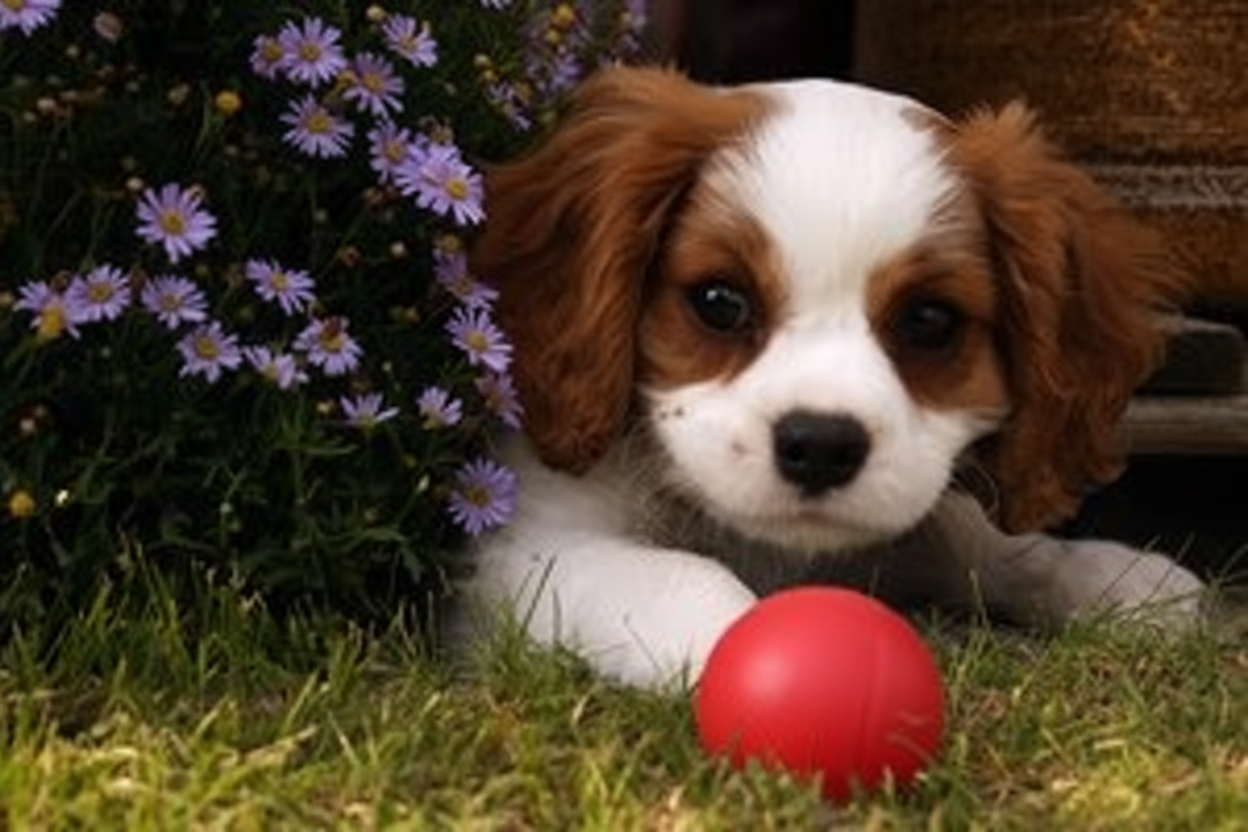



In [ ]:
chat_img = AsyncChat('gemini/gemini-2.5-flash-image-preview')
res = await chat_img([img_fn.read_bytes(), 'give the dog a red ball please.'], stream=True)
res =await adisplay_stream(res)

### Caching

#### Anthropic

We use explicit caching via cache control checkpoints. Anthropic requires exact match with cached tokens and even a small change results in cache invalidation.

In [ ]:
disable_cachy()

In [ ]:
a,b = random.randint(0,100), random.randint(0,100)
hist = [[f"What is {a}+{b}?\n" * 250], f"It's {a+b}", ['hi'], "Hello"]
msgs = mk_msgs(hist)

In this first api call we will see cache creation until the last user msg:

In [ ]:
sleep(5)
chat = AsyncChat(ms[2], cache=True, hist=hist)
rs = await chat('hi again', stream=True, stream_options={"include_usage": True})
async for o in rs: 
    if isinstance(o, ModelResponse): print(o.usage)

Usage(completion_tokens=13, prompt_tokens=2026, total_tokens=2039, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=2023), cache_creation_input_tokens=2023, cache_read_input_tokens=0)


In [ ]:
# flaky test
# cache_read_toks = o.usage.cache_creation_input_tokens
# test_eq(cache_read_toks > 1000, True)
# test_eq(o.usage.cache_read_input_tokens, 0)

In [ ]:
hist.extend([['hi again'], 'how may i help you?'])
chat = AsyncChat(ms[2], cache=True, hist=hist)
rs = await chat('bye!', stream=True, stream_options={"include_usage": True})
async for o in rs:
    if isinstance(o, ModelResponse): print(o.usage)

Usage(completion_tokens=17, prompt_tokens=2040, total_tokens=2057, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=2023, text_tokens=None, image_tokens=None, cache_creation_tokens=14), cache_creation_input_tokens=14, cache_read_input_tokens=2023)


The subsequent call should re-use the existing cache:

In [ ]:
# flaky test
# test_eq(o.usage.cache_read_input_tokens, cache_read_toks)

#### Gemini

Gemini implicit caching supports partial token matches. The usage metadata only shows cache hits with the `cached_tokens` field. So, to view them we need to run completions at least twice.

Testing with `gemini-2.5-flash` until `gemini-3-pro-preview` is more reliable

In [ ]:
chat = AsyncChat(ms[1], cache=True, hist=hist)
rs = await chat('hi again', stream=True, stream_options={"include_usage": True})
async for o in rs: 
    if isinstance(o, ModelResponse): print(o.usage)

Usage(completion_tokens=62, prompt_tokens=2526, total_tokens=2588, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=52, rejected_prediction_tokens=None, text_tokens=10, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=2526, image_tokens=None))


Running the same completion again:

In [ ]:
sleep(5) # it takes a while for cached tokens to be avail.
chat = AsyncChat(ms[1], cache=True, hist=hist)
rs = await chat('hi again', stream=True, stream_options={"include_usage": True})
async for o in rs: 
    if isinstance(o, ModelResponse): print(o.usage)

Usage(completion_tokens=73, prompt_tokens=1921, total_tokens=1994, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=63, rejected_prediction_tokens=None, text_tokens=10, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=1921, image_tokens=None))


In [ ]:
# flaky test
# test_eq(o.usage.prompt_tokens_details.cached_tokens > 1800, True)

In [ ]:
hist.extend([['hi again'], 'how may i help you?'])
chat = AsyncChat(ms[1], cache=True, hist=hist)
rs = await chat('bye!', stream=True, stream_options={"include_usage": True})
async for o in rs:
    if isinstance(o, ModelResponse): print(o.usage)

Usage(completion_tokens=36, prompt_tokens=1931, total_tokens=1967, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=29, rejected_prediction_tokens=None, text_tokens=7, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=1931, image_tokens=None))


In [ ]:
# flaky test
# test_eq(o.usage.prompt_tokens_details.cached_tokens > 2000, True)

Let's modify the cached content and see that partial matching works:

In [ ]:
c = hist[0][0]
hist[0][0] = c[:int(len(c)*0.75)] + " Some extra text"

In [ ]:
hist.extend([['hi again'], 'how may i help you?'])
chat = AsyncChat(ms[1], cache=True, hist=hist)
rs = await chat('bye!', stream=True, stream_options={"include_usage": True})
async for o in rs:
    if isinstance(o, ModelResponse): print(o.usage)

Usage(completion_tokens=36, prompt_tokens=1481, total_tokens=1517, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=29, rejected_prediction_tokens=None, text_tokens=7, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=1481, image_tokens=None))


In [ ]:
# flaky test
# test_eq(o.usage.prompt_tokens_details.cached_tokens > 900, True)

# Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()